In [2]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import cvxpy as cvx
from scipy.stats import norm
from numpy.linalg import inv
import math

import keras
import seaborn as sns
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt

# for plotting
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import matplotlib.pyplot as plt

# Initialize plotly offline
plotly.offline.init_notebook_mode(connected=True)

Using TensorFlow backend.


# Helper Functions

## Data functions

In [3]:
# Download Stock data from Yahoo Finance
def download_stock_data(start_date, end_date, asset_list, filename):
    """
    asset_list: list of asset to download
    filename: name of the csv file where the data go to
    """
    for i, asset in enumerate(asset_list):
        if i == 0:
            data = pdr.get_data_yahoo(asset_list[i], start_date,end_date)[['Adj Close']]
            all_prices = data.rename(columns={"Adj Close": asset})
            
        else:
            new_asset = pdr.get_data_yahoo(asset_list[i], start_date,end_date)[['Adj Close']]
            all_prices = all_prices.join(new_asset.rename(columns={"Adj Close": asset}))
    
    all_prices.to_csv('./00_Data/' + filename + '.csv')
    return

# Extract Return and accumulated price data (starting value 1) from raw stock prices
def process_stock_data(all_prices):
    """
    input:
    all_prices: data frame, price of a list of stock from start date to the end date
    
    return:
    all_price_norm: normalized asset price with the price on the first day as 1
    all_returns: relative price
    """
    n_time, n_assets = all_prices.shape
    # Calculate returns
    all_returns = all_prices.pct_change(1).apply(lambda a : a + 1)
    
    # Calculate relative price time series
    all_prices_norm = all_returns.copy()
    for i in range(n_time):
        if i == 0:
            all_prices_norm.iloc[i] = np.ones(n_assets) # all 1 on day 1
        else:
            for j in range(n_assets):
                if math.isnan(all_prices_norm.iloc[i,j]): # if NaN, use previous day's relative price
                    all_prices_norm.iloc[i,j] = all_prices_norm.iloc[i-1,j]
                else:
                    all_prices_norm.iloc[i,j] = all_prices_norm.iloc[i,j] * all_prices_norm.iloc[i-1,j]
                    
    return all_prices_norm, all_returns.dropna()

## Test stocks

In [4]:
#1/fluc, 1, 1/fluc, 1, ...
def teststock1(T, fluc):
    stock = np.ones(T+1)
    for i in range(T+1):
        if i%2 == 1:
            stock[i] = 1.0/fluc
    return stock

#Brownian Motion
def teststock2(T, delta, sigma):
    stock1 = np.zeros(T+1)
    stock1[0] = 3.0
    for i in range(T):
        stock1[i+1] = stock1[i] + sigma + norm.rvs(scale=delta**2)
        if (stock1[i+1] <= 0):
            print('Negative Warning!')
    return stock1

#Garbage 1, 1/fluc, 1/pow(fluc,2) ,...
def teststock3(T, discount):
    stock = np.ones(T+1, dtype=float)
    for i in range(T):
        stock[i+1] = stock[i]*discount
    return stock

## Risk Aware Portfolio Selection Algorithm
#### Bug: cannot initialize gamma as cp.Parameter

In [5]:
def Risk_Aware_Portfolio(stock_returns, gamma, delta):
    """
    input:
    stock_return: returns for the stock data
    gamma: the confidence level
    delta: number of dates we use to estimate the density of returns
    
    output:
    portfolio: portfolio selected
    """
    u = cp.Variable((stock_returns.shape[1], 1))
    a = cp.Variable()
    #     gamma = cp.Parameter(gamma)

    constraints = [cp.sum(u) == 1, u >= 0]

    portfolio = []

    for t in range(2, len(stock_returns)):
        coefficient = 1 / ((delta + t - 1) * (1 - gamma))

        sliced = stock_returns.iloc[:delta]
        sliced = sliced.to_numpy()
        inner_part = cp.pos(sliced * (-u) - a)
        first_sum = cp.sum(inner_part)

        sliced2 = stock_returns.iloc[:t - 1]
        sliced2 = sliced2.to_numpy()
        inner_part2 = sliced2 * (-u) - a
        second_sum = cp.sum(cp.pos(inner_part2))

        obj = cp.Minimize(a + coefficient * (first_sum + second_sum))

        prob = cp.Problem(obj, constraints)
        prob.solve(solver='SCS')
        portfolio.append(u.value)

    return portfolio

    """
    n_time, n_assets = stock_returns.shape
    portfolio = np.zeros((n_assets, n_time)) # the output portfolio
    u = cp.Variable(n_assets) # portfolio vector
    alpha = cp.Variable() # auxiliary variable
    
    constraints = [cp.sum(u) == 1, 
                u >= 0]
    Gamma = cp.Parameter(nonneg = True,value = gamma)
    
    for t in range(delta + 1, n_time):
        R = stock_returns.iloc[:t,:].dot(u).values
        fct =  alpha + (cp.pos(-cp.sum(R[:delta])-alpha)+cp.pos(-cp.sum(R[:t-1])-alpha))/((delta + t - 1)*(1 - Gamma))
        prob = cp.Problem(cp.Minimize(fct), constraints)
        p = prob.solve()
        portfolio[:,t] = u.value
        
    return portfolio
    """

## Normalization

In [6]:
def normalized(data):
    data_temp = data - np.mean(data)
    variance = np.sum(data ** 2)/len(data)
    data_temp /= variance
    return data_temp

## Load stock data

### US Stocks

In [7]:
us_stocks = ['SPY', # The SP500 as a benchmark
             'AAPL', 'MMM', 'BA' , 'CAT', 'CVX' , 'CSCO', 'KO' , 'DIS',
             'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'PFE'] #Some stocks from the Dow Jones

start_data = '2008-09-01'
end_date = '2008-10-01'

In [8]:
# download_stock_data(start_data, end_date, us_stocks, 'us_stocks_latest')

In [9]:
# read in the data again
us_stock_prices = pd.read_csv('./00_Data/us_stocks_latest.csv', header=0, index_col = 0)
us_stock_prices.index = pd.to_datetime(us_stock_prices.index)

#Process Stock Data
stock_prices_norm, stock_returns = process_stock_data(us_stock_prices)

# Extract benchmark SP500 Data
SPY_relative_price_benchmark = stock_prices_norm.drop(us_stocks[1:], axis=1)
SPY_returns_benchmark = stock_returns.drop(us_stocks[1:], axis=1)
us_stock_prices_norm_wo_SPY = stock_prices_norm.drop(us_stocks[0], axis=1)

# filter out benchmark data from stock returns
us_stock_returns = stock_returns.drop(us_stocks[0], axis=1)

### Hundred stocks

In [10]:
# Read in the data
hundred_stock_prices = pd.read_csv('./00_Data/hundred_stocks.csv', header=0, index_col = 0)

In [11]:
hundred_stock_prices.index = pd.to_datetime(hundred_stock_prices.index)

#Process Stock Data
hundred_stock_prices_norm, hundred_stock_returns = process_stock_data(hundred_stock_prices)

### Subprime mortgage crisis period data

In [12]:
subprime_mortgage_crisis = hundred_stock_prices.loc['2008-09'].dropna(axis=1) 
SPMC_relative_prices, SPMC_returns = process_stock_data(subprime_mortgage_crisis) # H_i,t of each asset i for t = 1,...,20

In [13]:
SPMC_SPY_relative_price_benchmark = SPY_relative_price_benchmark.loc['2008-09']

# Directions: Deep portfolio using neural network

Next we are to implement the deep portfolio. Recall the four step procedure: 
- **Auto-encoding**: this phase is essentially dimension reduction. *In the paper: one hidden layer with five neurons*.
- **Calibration**: using the stock price of the first few years, our target index $Y$ is the S&P500 (we can also play with this target so that the portfolio map can possibly outperform S&P500 -- but this is for later). *In the paper: ReLU and 4-fold cross validation*. 
- **Validation**: out-sample validation. Will need to test with different number of stocks.
- **Verification**: deep frontier. We look at the 2-norm out-of-sample error for different number of stocks used.

## 1. Auto-encoding

**Used Data**: 
- SPMC_returns: 20 daily returns during September of 2008 calculated with hundred_stocks.

**NN Model**: 
- 87 - 5 - 87

In [14]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)

# Import `Dense` from `keras.layers`
from keras.layers import Dense

### Constructing model

In [15]:
# Initialize the constructor
autoencoder_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
autoencoder_model.add(Dense(units = 5, input_dim = 87, activation='relu', use_bias = False))
autoencoder_model.add(Dense(units = 87, activation='relu', use_bias = False))

W0803 12:58:47.378619 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 12:58:47.420692 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 12:58:47.434842 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



### Set optimizer and learning rate

In [16]:
# autoencoder_opt = RMSprop(lr=0.001)

### Compile & Learn

In [17]:
autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

W0803 12:58:50.326987 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [18]:
autoencoder_model.fit(SPMC_returns, SPMC_returns, epochs = 500)

W0803 12:58:51.948224 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0803 12:58:52.008613 4715972032 deprecation_wrapper.py:119] From /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/500
20/20 [==============================] - 1s 59ms/step - loss: 2.1358 - mean_absolute_error: 0.8353
Epoch 2/500
20/20 [==============================] - 0s 126us/step - loss: 2.1189 - mean_absolute_error: 0.8240
Epoch 3/500
20/20 [==============================] - 0s 151us/step - loss: 2.1019 - mean_absolute_error: 0.8131
Epoch 4/500
20/20 [==============================] - 0s 154us/step - loss: 2.0868 - mean_absolute_error: 0.8032
Epoch 5/500
20/20 [==============================] - 0s 68us/step - loss: 2.0716 - mean_absolute_error: 0.7928
Epoch 6/500
20/20 [==============================] - 0s 116us/step - loss: 2.0562 - mean_absolute_error: 0.7812
Epoch 7/500
20/20 [==============================] - 0s 109us/step - loss: 2.0401 - mean_absolute_error: 0.7682
Epoch 8/500
20/20 [==============================] - 0s 43us/step - loss: 2.0249 - mean_absolute_error: 0.7554
Epoch 9/500
20/20 [==============================] - 0s 78us/step - loss: 2.0103 - mean_absolute_error: 0.7

Epoch 75/500
20/20 [==============================] - 0s 72us/step - loss: 1.5739 - mean_absolute_error: 0.5161
Epoch 76/500
20/20 [==============================] - 0s 75us/step - loss: 1.5686 - mean_absolute_error: 0.5143
Epoch 77/500
20/20 [==============================] - 0s 62us/step - loss: 1.5634 - mean_absolute_error: 0.5125
Epoch 78/500
20/20 [==============================] - 0s 63us/step - loss: 1.5583 - mean_absolute_error: 0.5105
Epoch 79/500
20/20 [==============================] - 0s 47us/step - loss: 1.5532 - mean_absolute_error: 0.5085
Epoch 80/500
20/20 [==============================] - 0s 57us/step - loss: 1.5481 - mean_absolute_error: 0.5064
Epoch 81/500
20/20 [==============================] - 0s 44us/step - loss: 1.5431 - mean_absolute_error: 0.5043
Epoch 82/500
20/20 [==============================] - 0s 65us/step - loss: 1.5382 - mean_absolute_error: 0.5024
Epoch 83/500
20/20 [==============================] - 0s 59us/step - loss: 1.5333 - mean_absolute_error:

Epoch 148/500
20/20 [==============================] - 0s 64us/step - loss: 1.2962 - mean_absolute_error: 0.4797
Epoch 149/500
20/20 [==============================] - 0s 51us/step - loss: 1.2929 - mean_absolute_error: 0.4797
Epoch 150/500
20/20 [==============================] - 0s 61us/step - loss: 1.2896 - mean_absolute_error: 0.4797
Epoch 151/500
20/20 [==============================] - 0s 58us/step - loss: 1.2863 - mean_absolute_error: 0.4797
Epoch 152/500
20/20 [==============================] - 0s 58us/step - loss: 1.2830 - mean_absolute_error: 0.4797
Epoch 153/500
20/20 [==============================] - 0s 52us/step - loss: 1.2797 - mean_absolute_error: 0.4796
Epoch 154/500
20/20 [==============================] - 0s 62us/step - loss: 1.2763 - mean_absolute_error: 0.4796
Epoch 155/500
20/20 [==============================] - 0s 51us/step - loss: 1.2729 - mean_absolute_error: 0.4795
Epoch 156/500
20/20 [==============================] - 0s 56us/step - loss: 1.2696 - mean_absolu

Epoch 221/500
20/20 [==============================] - 0s 124us/step - loss: 1.0144 - mean_absolute_error: 0.4621
Epoch 222/500
20/20 [==============================] - 0s 61us/step - loss: 1.0101 - mean_absolute_error: 0.4619
Epoch 223/500
20/20 [==============================] - 0s 55us/step - loss: 1.0058 - mean_absolute_error: 0.4617
Epoch 224/500
20/20 [==============================] - 0s 54us/step - loss: 1.0015 - mean_absolute_error: 0.4615
Epoch 225/500
20/20 [==============================] - 0s 114us/step - loss: 0.9971 - mean_absolute_error: 0.4613
Epoch 226/500
20/20 [==============================] - 0s 69us/step - loss: 0.9928 - mean_absolute_error: 0.4611
Epoch 227/500
20/20 [==============================] - 0s 55us/step - loss: 0.9885 - mean_absolute_error: 0.4609
Epoch 228/500
20/20 [==============================] - 0s 133us/step - loss: 0.9842 - mean_absolute_error: 0.4607
Epoch 229/500
20/20 [==============================] - 0s 284us/step - loss: 0.9799 - mean_ab

Epoch 294/500
20/20 [==============================] - 0s 309us/step - loss: 0.7078 - mean_absolute_error: 0.4427
Epoch 295/500
20/20 [==============================] - 0s 117us/step - loss: 0.7041 - mean_absolute_error: 0.4426
Epoch 296/500
20/20 [==============================] - 0s 59us/step - loss: 0.7004 - mean_absolute_error: 0.4424
Epoch 297/500
20/20 [==============================] - 0s 52us/step - loss: 0.6967 - mean_absolute_error: 0.4423
Epoch 298/500
20/20 [==============================] - 0s 186us/step - loss: 0.6930 - mean_absolute_error: 0.4422
Epoch 299/500
20/20 [==============================] - 0s 56us/step - loss: 0.6894 - mean_absolute_error: 0.4421
Epoch 300/500
20/20 [==============================] - 0s 129us/step - loss: 0.6858 - mean_absolute_error: 0.4421
Epoch 301/500
20/20 [==============================] - 0s 60us/step - loss: 0.6822 - mean_absolute_error: 0.4421
Epoch 302/500
20/20 [==============================] - 0s 47us/step - loss: 0.6786 - mean_ab

Epoch 367/500
20/20 [==============================] - 0s 56us/step - loss: 0.4953 - mean_absolute_error: 0.4394
Epoch 368/500
20/20 [==============================] - 0s 86us/step - loss: 0.4930 - mean_absolute_error: 0.4392
Epoch 369/500
20/20 [==============================] - 0s 76us/step - loss: 0.4906 - mean_absolute_error: 0.4389
Epoch 370/500
20/20 [==============================] - 0s 88us/step - loss: 0.4884 - mean_absolute_error: 0.4385
Epoch 371/500
20/20 [==============================] - 0s 86us/step - loss: 0.4861 - mean_absolute_error: 0.4379
Epoch 372/500
20/20 [==============================] - 0s 235us/step - loss: 0.4839 - mean_absolute_error: 0.4373
Epoch 373/500
20/20 [==============================] - 0s 107us/step - loss: 0.4818 - mean_absolute_error: 0.4366
Epoch 374/500
20/20 [==============================] - 0s 47us/step - loss: 0.4797 - mean_absolute_error: 0.4359
Epoch 375/500
20/20 [==============================] - 0s 168us/step - loss: 0.4776 - mean_abs

Epoch 440/500
20/20 [==============================] - 0s 78us/step - loss: 0.3892 - mean_absolute_error: 0.4073
Epoch 441/500
20/20 [==============================] - 0s 76us/step - loss: 0.3882 - mean_absolute_error: 0.4074
Epoch 442/500
20/20 [==============================] - 0s 73us/step - loss: 0.3872 - mean_absolute_error: 0.4074
Epoch 443/500
20/20 [==============================] - 0s 119us/step - loss: 0.3862 - mean_absolute_error: 0.4073
Epoch 444/500
20/20 [==============================] - 0s 57us/step - loss: 0.3852 - mean_absolute_error: 0.4072
Epoch 445/500
20/20 [==============================] - 0s 74us/step - loss: 0.3842 - mean_absolute_error: 0.4068
Epoch 446/500
20/20 [==============================] - 0s 58us/step - loss: 0.3833 - mean_absolute_error: 0.4064
Epoch 447/500
20/20 [==============================] - 0s 106us/step - loss: 0.3824 - mean_absolute_error: 0.4058
Epoch 448/500
20/20 [==============================] - 0s 86us/step - loss: 0.3815 - mean_abso

### Predict

In [19]:
autoencoder_result = autoencoder_model.predict(SPMC_returns)

### Visualize

In [20]:
pd.DataFrame(autoencoder_result)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.0,1.004191,0.956426,0.000000,0.000000,0.000000,1.021037,0.000000,0.947025,0.996212,...,0.000000,1.004470,0.992810,1.010724,1.016219,0.995067,1.022568,1.005382,0.982505,1.010128
1,0.0,0.989858,0.974864,0.949449,0.947367,0.963686,0.000000,0.946895,1.005871,0.968126,...,0.975017,0.976800,0.988871,0.993447,0.946486,0.971078,0.967073,1.005321,0.975759,0.964890
2,0.0,1.003247,0.951663,0.000000,0.000000,0.000000,1.021184,0.000000,0.943387,0.992619,...,0.000000,1.003457,0.988620,1.009861,1.015908,0.992711,1.022769,1.004392,0.978862,1.009305
3,0.0,0.936199,0.871648,0.000000,0.000000,0.000000,0.957635,0.000000,0.868664,0.914999,...,0.000000,0.936099,0.908715,0.942737,0.950749,0.920336,0.959355,0.937072,0.901888,0.942386
4,0.0,0.946184,0.885183,0.000000,0.000000,0.000000,0.966635,0.000000,0.880943,0.927671,...,0.000000,0.946158,0.921979,0.952697,0.960182,0.931709,0.968311,0.947116,0.914491,0.952299
5,0.0,1.008566,0.973703,0.000000,0.000000,0.000000,1.021734,0.000000,0.960475,1.009563,...,0.000000,1.009083,1.008184,1.014835,1.018463,1.004219,1.023079,1.009919,0.996015,1.014102
6,0.0,1.013345,0.992548,0.000000,0.000000,0.000000,1.014000,0.000000,0.977008,1.021221,...,0.000000,1.013636,1.025810,1.021720,1.022084,1.017114,1.030184,1.020058,1.008169,1.025092
7,0.0,1.008908,0.959107,0.000000,0.000000,0.000000,1.026353,0.000000,0.950185,0.999646,...,0.000000,1.009156,0.995946,1.015513,1.021295,0.999075,1.027917,1.010084,0.985845,1.014932
8,0.0,0.934679,0.873685,0.000000,0.000000,0.000000,0.932508,0.000000,0.869319,0.916695,...,0.000000,0.934738,0.909781,0.940312,0.947998,0.919027,0.954406,0.933910,0.903652,0.938361
9,0.0,1.006861,0.971276,0.000000,0.000000,0.000000,1.020229,0.000000,0.958296,1.007319,...,0.000000,1.007363,1.005821,1.013137,1.016870,1.002234,1.021584,1.008201,0.993781,1.012413


### Percentage error

In [21]:
pd.DataFrame(abs(autoencoder_result - SPMC_returns)/SPMC_returns) * 100

,BAC,CHK,GE,AMD,NOK,CSX,TEVA,ERIC,F,WFC,...,BX,GLW,SCHW,NUS,TXT,CX,OXY,CY,NEM,FLEX
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-03,100.0,0.596981,4.491279,100.000000,100.000000,100.000,0.042116,100.000000,6.540866,0.263721,...,100.000000,14.880796,0.842081,2.637565,2.679741,0.825833,2.040034,7.335563,1.668756,1.431056
2008-09-04,100.0,0.093965,0.548287,0.015199,0.082741,0.008,100.000000,0.714377,4.711383,1.185025,...,0.052062,0.327896,1.615372,0.059829,0.231395,0.563919,0.795839,0.190834,2.141290,0.531527
2008-09-05,100.0,1.048797,5.448094,100.000000,100.000000,100.000,2.891368,100.000000,6.089175,5.605731,...,100.000000,0.195424,3.313073,1.779852,1.358102,1.071164,2.723608,0.611422,3.792736,2.389711
2008-09-08,100.0,2.829841,16.460853,100.000000,100.000000,100.000,2.722868,100.000000,15.806385,14.934560,...,100.000000,5.769067,13.200058,8.599809,4.414119,12.246029,2.722762,5.219828,8.882553,8.409769
2008-09-09,100.0,3.936648,8.428318,100.000000,100.000000,100.000,2.187481,100.000000,8.902437,0.119874,...,100.000000,1.954335,1.011914,2.909190,0.899179,2.859562,5.260133,4.182761,0.857618,0.901103
2008-09-10,100.0,2.308455,2.525692,100.000000,100.000000,100.000,2.416836,100.000000,5.456554,0.731588,...,100.000000,0.460340,0.452954,0.068561,0.073776,0.274607,3.096021,2.935155,2.986883,1.916032
2008-09-11,100.0,1.309255,0.991866,100.000000,100.000000,100.000,0.291985,100.000000,6.683164,4.364225,...,100.000000,1.426175,0.391835,2.412968,0.743509,3.225733,3.018415,0.968708,1.979688,1.305661
2008-09-12,100.0,4.122686,0.966154,100.000000,100.000000,100.000,2.855617,100.000000,9.432526,1.318157,...,100.000000,0.737742,1.796725,1.312324,1.762143,7.654323,0.896697,0.366380,7.331622,0.170453
2008-09-15,100.0,2.943776,4.995607,100.000000,100.000000,100.000,5.181422,100.000000,9.950267,1.398225,...,100.000000,0.485808,3.931949,3.934433,1.726160,1.003372,2.211408,4.886433,6.621102,3.769529


## 2. Calibration
#### Note: Autoencoder used daily returns; using relative prices here.
**Inputted Data**: 
- autoencoder_result: The autoencoder's representation of SPMC_returns.
- SPMC_relative_prices: 21 days of relative prices during September of 2008 calculated with hundred_stocks.
- SPMC_SPY_relative_price_benchmark: 21 days of relative prices during September of 2008.

**Important variables**:
- top10_bot10: 20 stocks that the autoencoder did the best/worst with predicting.

**NN Model**: 
- 10 - 3 - 1

### Sort & pick stocks

In [22]:
# Error
autoencoder_prediction_error_norm2 = np.linalg.norm(abs(autoencoder_result - SPMC_returns.values), axis = 0) # Norm2 across columns
sorted_autoencoder_prediction_error_norm2 = np.sort(autoencoder_prediction_error_norm2).tolist()
sorted_stocks = [autoencoder_prediction_error_norm2.tolist().index(x) for x in sorted_autoencoder_prediction_error_norm2] # Find corresponding stocks
top10_bot10_index = sorted_stocks[:5] + sorted_stocks[-5:] # Represent stocks as original indices from norm2


In [23]:
top10_bot10 = SPMC_relative_prices.iloc[:,top10_bot10_index]

### Constructing model

In [24]:
dfp_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
dfp_model.add(Dense(units = 3, input_dim = 10, activation='relu', use_bias = False))
dfp_model.add(Dense(units = 1, activation='relu', use_bias = False))


### Set optimizer and learning rate

In [25]:
# dfp_opt = RMSprop(lr=0.0001) # Seems like adam is resolving problem of getting stuck at 2.0 MAE

### Compile & learn

In [26]:
dfp_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [27]:
dfp_model.fit(top10_bot10, SPMC_SPY_relative_price_benchmark, epochs = 10000, verbose = 1)

Epoch 1/10000
21/21 [==============================] - 0s 7ms/step - loss: 0.2451 - mean_absolute_error: 0.4924
Epoch 2/10000
21/21 [==============================] - 0s 68us/step - loss: 0.2414 - mean_absolute_error: 0.4886
Epoch 3/10000
21/21 [==============================] - 0s 97us/step - loss: 0.2364 - mean_absolute_error: 0.4835
Epoch 4/10000
21/21 [==============================] - 0s 121us/step - loss: 0.2319 - mean_absolute_error: 0.4788
Epoch 5/10000
21/21 [==============================] - 0s 83us/step - loss: 0.2273 - mean_absolute_error: 0.4740
Epoch 6/10000
21/21 [==============================] - 0s 92us/step - loss: 0.2225 - mean_absolute_error: 0.4688
Epoch 7/10000
21/21 [==============================] - 0s 76us/step - loss: 0.2177 - mean_absolute_error: 0.4637
Epoch 8/10000
21/21 [==============================] - 0s 116us/step - loss: 0.2129 - mean_absolute_error: 0.4585
Epoch 9/10000
21/21 [==============================] - 0s 85us/step - loss: 0.2081 - mean_absol

Epoch 73/10000
21/21 [==============================] - 0s 67us/step - loss: 0.0224 - mean_absolute_error: 0.1377
Epoch 74/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0213 - mean_absolute_error: 0.1338
Epoch 75/10000
21/21 [==============================] - 0s 72us/step - loss: 0.0204 - mean_absolute_error: 0.1301
Epoch 76/10000
21/21 [==============================] - 0s 85us/step - loss: 0.0194 - mean_absolute_error: 0.1264
Epoch 77/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0185 - mean_absolute_error: 0.1229
Epoch 78/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0177 - mean_absolute_error: 0.1197
Epoch 79/10000
21/21 [==============================] - 0s 47us/step - loss: 0.0168 - mean_absolute_error: 0.1166
Epoch 80/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0161 - mean_absolute_error: 0.1135
Epoch 81/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0153 - me

Epoch 145/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0039 - mean_absolute_error: 0.0551
Epoch 146/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0039 - mean_absolute_error: 0.0550
Epoch 147/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0039 - mean_absolute_error: 0.0549
Epoch 148/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0039 - mean_absolute_error: 0.0549
Epoch 149/10000
21/21 [==============================] - 0s 122us/step - loss: 0.0039 - mean_absolute_error: 0.0548
Epoch 150/10000
21/21 [==============================] - 0s 103us/step - loss: 0.0039 - mean_absolute_error: 0.0548
Epoch 151/10000
21/21 [==============================] - 0s 97us/step - loss: 0.0038 - mean_absolute_error: 0.0547
Epoch 152/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0038 - mean_absolute_error: 0.0546
Epoch 153/10000
21/21 [==============================] - 0s 65us/step - loss:

21/21 [==============================] - 0s 93us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 217/10000
21/21 [==============================] - 0s 127us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 218/10000
21/21 [==============================] - 0s 68us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 219/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 220/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 221/10000
21/21 [==============================] - 0s 41us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 222/10000
21/21 [==============================] - 0s 47us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 223/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0038 - mean_absolute_error: 0.0540
Epoch 224/10000
21/21 [==============================] - 0s 63us/step - loss: 0.0038 - mean_abs

Epoch 288/10000
21/21 [==============================] - 0s 123us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 289/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 290/10000
21/21 [==============================] - 0s 138us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 291/10000
21/21 [==============================] - 0s 126us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 292/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 293/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 294/10000
21/21 [==============================] - 0s 92us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 295/10000
21/21 [==============================] - 0s 109us/step - loss: 0.0038 - mean_absolute_error: 0.0538
Epoch 296/10000
21/21 [==============================] - 0s 55us/step - loss

21/21 [==============================] - 0s 124us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 360/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 361/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 362/10000
21/21 [==============================] - 0s 71us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 363/10000
21/21 [==============================] - 0s 138us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 364/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 365/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 366/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0037 - mean_absolute_error: 0.0535
Epoch 367/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0037 - mean_ab

Epoch 431/10000
21/21 [==============================] - 0s 113us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 432/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 433/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 434/10000
21/21 [==============================] - 0s 497us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 435/10000
21/21 [==============================] - 0s 76us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 436/10000
21/21 [==============================] - 0s 83us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 437/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 438/10000
21/21 [==============================] - 0s 204us/step - loss: 0.0037 - mean_absolute_error: 0.0532
Epoch 439/10000
21/21 [==============================] - 0s 97us/step - loss:

Epoch 503/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 504/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 505/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 506/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 507/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 508/10000
21/21 [==============================] - 0s 136us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 509/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0037 - mean_absolute_error: 0.0528
Epoch 510/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0036 - mean_absolute_error: 0.0528
Epoch 511/10000
21/21 [==============================] - 0s 74us/step - loss: 0

21/21 [==============================] - 0s 99us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 575/10000
21/21 [==============================] - 0s 274us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 576/10000
21/21 [==============================] - 0s 113us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 577/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 578/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 579/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 580/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 581/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0036 - mean_absolute_error: 0.0524
Epoch 582/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0036 - mean_ab

Epoch 646/10000
21/21 [==============================] - 0s 108us/step - loss: 0.0036 - mean_absolute_error: 0.0520
Epoch 647/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0036 - mean_absolute_error: 0.0520
Epoch 648/10000
21/21 [==============================] - 0s 176us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 649/10000
21/21 [==============================] - 0s 74us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 650/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 651/10000
21/21 [==============================] - 0s 129us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 652/10000
21/21 [==============================] - 0s 106us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 653/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0035 - mean_absolute_error: 0.0520
Epoch 654/10000
21/21 [==============================] - 0s 154us/step - los

Epoch 718/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 719/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 720/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 721/10000
21/21 [==============================] - 0s 67us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 722/10000
21/21 [==============================] - 0s 85us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 723/10000
21/21 [==============================] - 0s 172us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 724/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 725/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0035 - mean_absolute_error: 0.0516
Epoch 726/10000
21/21 [==============================] - 0s 134us/step - loss: 

21/21 [==============================] - 0s 248us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 790/10000
21/21 [==============================] - 0s 249us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 791/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 792/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 793/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 794/10000
21/21 [==============================] - 0s 49us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 795/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 796/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0034 - mean_absolute_error: 0.0511
Epoch 797/10000
21/21 [==============================] - 0s 147us/step - loss: 0.0034 - mean_a

Epoch 861/10000
21/21 [==============================] - 0s 101us/step - loss: 0.0034 - mean_absolute_error: 0.0507
Epoch 862/10000
21/21 [==============================] - 0s 71us/step - loss: 0.0034 - mean_absolute_error: 0.0507
Epoch 863/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0034 - mean_absolute_error: 0.0507
Epoch 864/10000
21/21 [==============================] - 0s 106us/step - loss: 0.0034 - mean_absolute_error: 0.0507
Epoch 865/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0034 - mean_absolute_error: 0.0506
Epoch 866/10000
21/21 [==============================] - 0s 44us/step - loss: 0.0034 - mean_absolute_error: 0.0506
Epoch 867/10000
21/21 [==============================] - 0s 62us/step - loss: 0.0034 - mean_absolute_error: 0.0506
Epoch 868/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0034 - mean_absolute_error: 0.0506
Epoch 869/10000
21/21 [==============================] - 0s 44us/step - loss: 

Epoch 933/10000
21/21 [==============================] - 0s 71us/step - loss: 0.0033 - mean_absolute_error: 0.0502
Epoch 934/10000
21/21 [==============================] - 0s 113us/step - loss: 0.0033 - mean_absolute_error: 0.0502
Epoch 935/10000
21/21 [==============================] - 0s 75us/step - loss: 0.0033 - mean_absolute_error: 0.0502
Epoch 936/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0033 - mean_absolute_error: 0.0502
Epoch 937/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0033 - mean_absolute_error: 0.0501
Epoch 938/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0033 - mean_absolute_error: 0.0501
Epoch 939/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0033 - mean_absolute_error: 0.0501
Epoch 940/10000
21/21 [==============================] - 0s 111us/step - loss: 0.0033 - mean_absolute_error: 0.0501
Epoch 941/10000
21/21 [==============================] - 0s 186us/step - loss:

21/21 [==============================] - 0s 55us/step - loss: 0.0033 - mean_absolute_error: 0.0497
Epoch 1005/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0033 - mean_absolute_error: 0.0497
Epoch 1006/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0033 - mean_absolute_error: 0.0497
Epoch 1007/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0033 - mean_absolute_error: 0.0496
Epoch 1008/10000
21/21 [==============================] - 0s 103us/step - loss: 0.0032 - mean_absolute_error: 0.0496
Epoch 1009/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0032 - mean_absolute_error: 0.0496
Epoch 1010/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0032 - mean_absolute_error: 0.0496
Epoch 1011/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0032 - mean_absolute_error: 0.0496
Epoch 1012/10000
21/21 [==============================] - 0s 115us/step - loss: 0.0032 

Epoch 1075/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1076/10000
21/21 [==============================] - 0s 43us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1077/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1078/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1079/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1080/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1081/10000
21/21 [==============================] - 0s 179us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1082/10000
21/21 [==============================] - 0s 113us/step - loss: 0.0032 - mean_absolute_error: 0.0491
Epoch 1083/10000
21/21 [==============================] - 0s 59us/step

Epoch 1146/10000
21/21 [==============================] - 0s 101us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1147/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1148/10000
21/21 [==============================] - 0s 204us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1149/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1150/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1151/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1152/10000
21/21 [==============================] - 0s 141us/step - loss: 0.0031 - mean_absolute_error: 0.0486
Epoch 1153/10000
21/21 [==============================] - 0s 49us/step - loss: 0.0031 - mean_absolute_error: 0.0485
Epoch 1154/10000
21/21 [==============================] - 0s 123us/s

Epoch 1217/10000
21/21 [==============================] - 0s 81us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1218/10000
21/21 [==============================] - 0s 67us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1219/10000
21/21 [==============================] - 0s 79us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1220/10000
21/21 [==============================] - 0s 228us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1221/10000
21/21 [==============================] - 0s 110us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1222/10000
21/21 [==============================] - 0s 79us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1223/10000
21/21 [==============================] - 0s 131us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1224/10000
21/21 [==============================] - 0s 83us/step - loss: 0.0031 - mean_absolute_error: 0.0480
Epoch 1225/10000
21/21 [==============================] - 0s 77us/ste

Epoch 1288/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0030 - mean_absolute_error: 0.0475
Epoch 1289/10000
21/21 [==============================] - 0s 128us/step - loss: 0.0030 - mean_absolute_error: 0.0475
Epoch 1290/10000
21/21 [==============================] - 0s 233us/step - loss: 0.0030 - mean_absolute_error: 0.0475
Epoch 1291/10000
21/21 [==============================] - 0s 116us/step - loss: 0.0030 - mean_absolute_error: 0.0475
Epoch 1292/10000
21/21 [==============================] - 0s 82us/step - loss: 0.0030 - mean_absolute_error: 0.0474
Epoch 1293/10000
21/21 [==============================] - 0s 116us/step - loss: 0.0030 - mean_absolute_error: 0.0474
Epoch 1294/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0030 - mean_absolute_error: 0.0474
Epoch 1295/10000
21/21 [==============================] - 0s 130us/step - loss: 0.0030 - mean_absolute_error: 0.0474
Epoch 1296/10000
21/21 [==============================] - 0s 78us/s

Epoch 1359/10000
21/21 [==============================] - 0s 79us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1360/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1361/10000
21/21 [==============================] - 0s 87us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1362/10000
21/21 [==============================] - 0s 186us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1363/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1364/10000
21/21 [==============================] - 0s 49us/step - loss: 0.0029 - mean_absolute_error: 0.0469
Epoch 1365/10000
21/21 [==============================] - 0s 81us/step - loss: 0.0029 - mean_absolute_error: 0.0468
Epoch 1366/10000
21/21 [==============================] - 0s 252us/step - loss: 0.0029 - mean_absolute_error: 0.0468
Epoch 1367/10000
21/21 [==============================] - 0s 142us/ste

Epoch 1430/10000
21/21 [==============================] - 0s 154us/step - loss: 0.0029 - mean_absolute_error: 0.0463
Epoch 1431/10000
21/21 [==============================] - 0s 112us/step - loss: 0.0029 - mean_absolute_error: 0.0463
Epoch 1432/10000
21/21 [==============================] - 0s 71us/step - loss: 0.0029 - mean_absolute_error: 0.0463
Epoch 1433/10000
21/21 [==============================] - 0s 92us/step - loss: 0.0029 - mean_absolute_error: 0.0463
Epoch 1434/10000
21/21 [==============================] - 0s 114us/step - loss: 0.0029 - mean_absolute_error: 0.0463
Epoch 1435/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0028 - mean_absolute_error: 0.0463
Epoch 1436/10000
21/21 [==============================] - 0s 101us/step - loss: 0.0028 - mean_absolute_error: 0.0463
Epoch 1437/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0028 - mean_absolute_error: 0.0462
Epoch 1438/10000
21/21 [==============================] - 0s 126us/s

Epoch 1501/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1502/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1503/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1504/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1505/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1506/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0028 - mean_absolute_error: 0.0457
Epoch 1507/10000
21/21 [==============================] - 0s 46us/step - loss: 0.0028 - mean_absolute_error: 0.0456
Epoch 1508/10000
21/21 [==============================] - 0s 75us/step - loss: 0.0028 - mean_absolute_error: 0.0456
Epoch 1509/10000
21/21 [==============================] - 0s 57us/step -

Epoch 1572/10000
21/21 [==============================] - 0s 139us/step - loss: 0.0027 - mean_absolute_error: 0.0451
Epoch 1573/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0027 - mean_absolute_error: 0.0451
Epoch 1574/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0027 - mean_absolute_error: 0.0451
Epoch 1575/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0027 - mean_absolute_error: 0.0451
Epoch 1576/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0027 - mean_absolute_error: 0.0450
Epoch 1577/10000
21/21 [==============================] - 0s 77us/step - loss: 0.0027 - mean_absolute_error: 0.0450
Epoch 1578/10000
21/21 [==============================] - 0s 80us/step - loss: 0.0027 - mean_absolute_error: 0.0450
Epoch 1579/10000
21/21 [==============================] - 0s 74us/step - loss: 0.0027 - mean_absolute_error: 0.0450
Epoch 1580/10000
21/21 [==============================] - 0s 121us/step

Epoch 1643/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0026 - mean_absolute_error: 0.0445
Epoch 1644/10000
21/21 [==============================] - 0s 90us/step - loss: 0.0026 - mean_absolute_error: 0.0445
Epoch 1645/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1646/10000
21/21 [==============================] - 0s 118us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1647/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1648/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1649/10000
21/21 [==============================] - 0s 42us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1650/10000
21/21 [==============================] - 0s 178us/step - loss: 0.0026 - mean_absolute_error: 0.0444
Epoch 1651/10000
21/21 [==============================] - 0s 47us/step

Epoch 1714/10000
21/21 [==============================] - 0s 104us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1715/10000
21/21 [==============================] - 0s 98us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1716/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1717/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1718/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1719/10000
21/21 [==============================] - 0s 62us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1720/10000
21/21 [==============================] - 0s 80us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1721/10000
21/21 [==============================] - 0s 68us/step - loss: 0.0026 - mean_absolute_error: 0.0438
Epoch 1722/10000
21/21 [==============================] - 0s 61us/step 

Epoch 1785/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0025 - mean_absolute_error: 0.0432
Epoch 1786/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0025 - mean_absolute_error: 0.0432
Epoch 1787/10000
21/21 [==============================] - 0s 168us/step - loss: 0.0025 - mean_absolute_error: 0.0432
Epoch 1788/10000
21/21 [==============================] - 0s 123us/step - loss: 0.0025 - mean_absolute_error: 0.0432
Epoch 1789/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0025 - mean_absolute_error: 0.0432
Epoch 1790/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0025 - mean_absolute_error: 0.0431
Epoch 1791/10000
21/21 [==============================] - 0s 276us/step - loss: 0.0025 - mean_absolute_error: 0.0431
Epoch 1792/10000
21/21 [==============================] - 0s 90us/step - loss: 0.0025 - mean_absolute_error: 0.0431
Epoch 1793/10000
21/21 [==============================] - 0s 62us/ste

Epoch 1856/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0024 - mean_absolute_error: 0.0426
Epoch 1857/10000
21/21 [==============================] - 0s 203us/step - loss: 0.0024 - mean_absolute_error: 0.0426
Epoch 1858/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0024 - mean_absolute_error: 0.0426
Epoch 1859/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0024 - mean_absolute_error: 0.0426
Epoch 1860/10000
21/21 [==============================] - 0s 147us/step - loss: 0.0024 - mean_absolute_error: 0.0425
Epoch 1861/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0024 - mean_absolute_error: 0.0425
Epoch 1862/10000
21/21 [==============================] - 0s 126us/step - loss: 0.0024 - mean_absolute_error: 0.0425
Epoch 1863/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0024 - mean_absolute_error: 0.0425
Epoch 1864/10000
21/21 [==============================] - 0s 84us/ste

Epoch 1927/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0024 - mean_absolute_error: 0.0420
Epoch 1928/10000
21/21 [==============================] - 0s 106us/step - loss: 0.0024 - mean_absolute_error: 0.0420
Epoch 1929/10000
21/21 [==============================] - 0s 97us/step - loss: 0.0024 - mean_absolute_error: 0.0420
Epoch 1930/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0024 - mean_absolute_error: 0.0419
Epoch 1931/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0024 - mean_absolute_error: 0.0419
Epoch 1932/10000
21/21 [==============================] - 0s 88us/step - loss: 0.0024 - mean_absolute_error: 0.0419
Epoch 1933/10000
21/21 [==============================] - 0s 107us/step - loss: 0.0024 - mean_absolute_error: 0.0419
Epoch 1934/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0024 - mean_absolute_error: 0.0419
Epoch 1935/10000
21/21 [==============================] - 0s 89us/step

Epoch 1998/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0023 - mean_absolute_error: 0.0414
Epoch 1999/10000
21/21 [==============================] - 0s 99us/step - loss: 0.0023 - mean_absolute_error: 0.0414
Epoch 2000/10000
21/21 [==============================] - 0s 85us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2001/10000
21/21 [==============================] - 0s 99us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2002/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2003/10000
21/21 [==============================] - 0s 136us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2004/10000
21/21 [==============================] - 0s 90us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2005/10000
21/21 [==============================] - 0s 91us/step - loss: 0.0023 - mean_absolute_error: 0.0413
Epoch 2006/10000
21/21 [==============================] - 0s 102us/step

Epoch 2069/10000
21/21 [==============================] - 0s 65us/step - loss: 0.0022 - mean_absolute_error: 0.0408
Epoch 2070/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2071/10000
21/21 [==============================] - 0s 82us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2072/10000
21/21 [==============================] - 0s 47us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2073/10000
21/21 [==============================] - 0s 70us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2074/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2075/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2076/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0022 - mean_absolute_error: 0.0407
Epoch 2077/10000
21/21 [==============================] - 0s 109us/step

Epoch 2140/10000
21/21 [==============================] - 0s 64us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2141/10000
21/21 [==============================] - 0s 41us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2142/10000
21/21 [==============================] - 0s 215us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2143/10000
21/21 [==============================] - 0s 93us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2144/10000
21/21 [==============================] - 0s 92us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2145/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2146/10000
21/21 [==============================] - 0s 166us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2147/10000
21/21 [==============================] - 0s 79us/step - loss: 0.0022 - mean_absolute_error: 0.0401
Epoch 2148/10000
21/21 [==============================] - 0s 71us/step

Epoch 2211/10000
21/21 [==============================] - 0s 98us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2212/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2213/10000
21/21 [==============================] - 0s 132us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2214/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2215/10000
21/21 [==============================] - 0s 87us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2216/10000
21/21 [==============================] - 0s 45us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2217/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2218/10000
21/21 [==============================] - 0s 206us/step - loss: 0.0021 - mean_absolute_error: 0.0395
Epoch 2219/10000
21/21 [==============================] - 0s 134us/ste

Epoch 2282/10000
21/21 [==============================] - 0s 72us/step - loss: 0.0020 - mean_absolute_error: 0.0389
Epoch 2283/10000
21/21 [==============================] - 0s 62us/step - loss: 0.0020 - mean_absolute_error: 0.0389
Epoch 2284/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0020 - mean_absolute_error: 0.0389
Epoch 2285/10000
21/21 [==============================] - 0s 65us/step - loss: 0.0020 - mean_absolute_error: 0.0389
Epoch 2286/10000
21/21 [==============================] - 0s 147us/step - loss: 0.0020 - mean_absolute_error: 0.0389
Epoch 2287/10000
21/21 [==============================] - 0s 76us/step - loss: 0.0020 - mean_absolute_error: 0.0388
Epoch 2288/10000
21/21 [==============================] - 0s 47us/step - loss: 0.0020 - mean_absolute_error: 0.0388
Epoch 2289/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0020 - mean_absolute_error: 0.0388
Epoch 2290/10000
21/21 [==============================] - 0s 85us/step

Epoch 2353/10000
21/21 [==============================] - 0s 360us/step - loss: 0.0020 - mean_absolute_error: 0.0383
Epoch 2354/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0020 - mean_absolute_error: 0.0383
Epoch 2355/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2356/10000
21/21 [==============================] - 0s 82us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2357/10000
21/21 [==============================] - 0s 98us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2358/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2359/10000
21/21 [==============================] - 0s 88us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2360/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0020 - mean_absolute_error: 0.0382
Epoch 2361/10000
21/21 [==============================] - 0s 53us/step 

Epoch 2424/10000
21/21 [==============================] - 0s 88us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2425/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2426/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2427/10000
21/21 [==============================] - 0s 280us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2428/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2429/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2430/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2431/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0019 - mean_absolute_error: 0.0376
Epoch 2432/10000
21/21 [==============================] - 0s 86us/ste

Epoch 2495/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2496/10000
21/21 [==============================] - 0s 164us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2497/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2498/10000
21/21 [==============================] - 0s 90us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2499/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2500/10000
21/21 [==============================] - 0s 72us/step - loss: 0.0019 - mean_absolute_error: 0.0370
Epoch 2501/10000
21/21 [==============================] - 0s 97us/step - loss: 0.0019 - mean_absolute_error: 0.0369
Epoch 2502/10000
21/21 [==============================] - 0s 180us/step - loss: 0.0019 - mean_absolute_error: 0.0369
Epoch 2503/10000
21/21 [==============================] - 0s 58us/step

Epoch 2566/10000
21/21 [==============================] - 0s 149us/step - loss: 0.0018 - mean_absolute_error: 0.0364
Epoch 2567/10000
21/21 [==============================] - 0s 114us/step - loss: 0.0018 - mean_absolute_error: 0.0364
Epoch 2568/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2569/10000
21/21 [==============================] - 0s 90us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2570/10000
21/21 [==============================] - 0s 65us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2571/10000
21/21 [==============================] - 0s 81us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2572/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2573/10000
21/21 [==============================] - 0s 108us/step - loss: 0.0018 - mean_absolute_error: 0.0363
Epoch 2574/10000
21/21 [==============================] - 0s 105us/st

Epoch 2637/10000
21/21 [==============================] - 0s 102us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2638/10000
21/21 [==============================] - 0s 92us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2639/10000
21/21 [==============================] - 0s 267us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2640/10000
21/21 [==============================] - 0s 135us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2641/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2642/10000
21/21 [==============================] - 0s 63us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2643/10000
21/21 [==============================] - 0s 71us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2644/10000
21/21 [==============================] - 0s 75us/step - loss: 0.0017 - mean_absolute_error: 0.0357
Epoch 2645/10000
21/21 [==============================] - 0s 160us/st

Epoch 2708/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0017 - mean_absolute_error: 0.0351
Epoch 2709/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0017 - mean_absolute_error: 0.0351
Epoch 2710/10000
21/21 [==============================] - 0s 81us/step - loss: 0.0017 - mean_absolute_error: 0.0351
Epoch 2711/10000
21/21 [==============================] - 0s 139us/step - loss: 0.0017 - mean_absolute_error: 0.0351
Epoch 2712/10000
21/21 [==============================] - 0s 143us/step - loss: 0.0017 - mean_absolute_error: 0.0351
Epoch 2713/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0017 - mean_absolute_error: 0.0350
Epoch 2714/10000
21/21 [==============================] - 0s 60us/step - loss: 0.0017 - mean_absolute_error: 0.0350
Epoch 2715/10000
21/21 [==============================] - 0s 126us/step - loss: 0.0017 - mean_absolute_error: 0.0350
Epoch 2716/10000
21/21 [==============================] - 0s 113us/st

Epoch 2779/10000
21/21 [==============================] - 0s 49us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2780/10000
21/21 [==============================] - 0s 73us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2781/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2782/10000
21/21 [==============================] - 0s 49us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2783/10000
21/21 [==============================] - 0s 48us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2784/10000
21/21 [==============================] - 0s 131us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2785/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2786/10000
21/21 [==============================] - 0s 94us/step - loss: 0.0016 - mean_absolute_error: 0.0344
Epoch 2787/10000
21/21 [==============================] - 0s 154us/step

Epoch 2850/10000
21/21 [==============================] - 0s 47us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2851/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2852/10000
21/21 [==============================] - 0s 214us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2853/10000
21/21 [==============================] - 0s 155us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2854/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2855/10000
21/21 [==============================] - 0s 130us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2856/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0016 - mean_absolute_error: 0.0338
Epoch 2857/10000
21/21 [==============================] - 0s 42us/step - loss: 0.0016 - mean_absolute_error: 0.0337
Epoch 2858/10000
21/21 [==============================] - 0s 70us/ste

Epoch 2921/10000
21/21 [==============================] - 0s 237us/step - loss: 0.0015 - mean_absolute_error: 0.0332
Epoch 2922/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0015 - mean_absolute_error: 0.0332
Epoch 2923/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0015 - mean_absolute_error: 0.0332
Epoch 2924/10000
21/21 [==============================] - 0s 52us/step - loss: 0.0015 - mean_absolute_error: 0.0331
Epoch 2925/10000
21/21 [==============================] - 0s 253us/step - loss: 0.0015 - mean_absolute_error: 0.0331
Epoch 2926/10000
21/21 [==============================] - 0s 82us/step - loss: 0.0015 - mean_absolute_error: 0.0331
Epoch 2927/10000
21/21 [==============================] - 0s 99us/step - loss: 0.0015 - mean_absolute_error: 0.0331
Epoch 2928/10000
21/21 [==============================] - 0s 72us/step - loss: 0.0015 - mean_absolute_error: 0.0331
Epoch 2929/10000
21/21 [==============================] - 0s 102us/ste

Epoch 2992/10000
21/21 [==============================] - 0s 94us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2993/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2994/10000
21/21 [==============================] - 0s 87us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2995/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2996/10000
21/21 [==============================] - 0s 98us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2997/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2998/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 2999/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0015 - mean_absolute_error: 0.0325
Epoch 3000/10000
21/21 [==============================] - 0s 128us/step 

Epoch 3063/10000
21/21 [==============================] - 0s 116us/step - loss: 0.0014 - mean_absolute_error: 0.0319
Epoch 3064/10000
21/21 [==============================] - 0s 87us/step - loss: 0.0014 - mean_absolute_error: 0.0319
Epoch 3065/10000
21/21 [==============================] - 0s 41us/step - loss: 0.0014 - mean_absolute_error: 0.0319
Epoch 3066/10000
21/21 [==============================] - 0s 110us/step - loss: 0.0014 - mean_absolute_error: 0.0319
Epoch 3067/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0014 - mean_absolute_error: 0.0319
Epoch 3068/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0014 - mean_absolute_error: 0.0318
Epoch 3069/10000
21/21 [==============================] - 0s 127us/step - loss: 0.0014 - mean_absolute_error: 0.0318
Epoch 3070/10000
21/21 [==============================] - 0s 75us/step - loss: 0.0014 - mean_absolute_error: 0.0318
Epoch 3071/10000
21/21 [==============================] - 0s 62us/ste

Epoch 3134/10000
21/21 [==============================] - 0s 123us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3135/10000
21/21 [==============================] - 0s 56us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3136/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3137/10000
21/21 [==============================] - 0s 106us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3138/10000
21/21 [==============================] - 0s 68us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3139/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3140/10000
21/21 [==============================] - 0s 78us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3141/10000
21/21 [==============================] - 0s 94us/step - loss: 0.0014 - mean_absolute_error: 0.0312
Epoch 3142/10000
21/21 [==============================] - 0s 56us/ste

Epoch 3205/10000
21/21 [==============================] - 0s 57us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3206/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3207/10000
21/21 [==============================] - 0s 101us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3208/10000
21/21 [==============================] - 0s 79us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3209/10000
21/21 [==============================] - 0s 141us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3210/10000
21/21 [==============================] - 0s 95us/step - loss: 0.0013 - mean_absolute_error: 0.0306
Epoch 3211/10000
21/21 [==============================] - 0s 94us/step - loss: 0.0013 - mean_absolute_error: 0.0305
Epoch 3212/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0013 - mean_absolute_error: 0.0305
Epoch 3213/10000
21/21 [==============================] - 0s 96us/step

Epoch 3276/10000
21/21 [==============================] - 0s 68us/step - loss: 0.0013 - mean_absolute_error: 0.0300
Epoch 3277/10000
21/21 [==============================] - 0s 121us/step - loss: 0.0013 - mean_absolute_error: 0.0300
Epoch 3278/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3279/10000
21/21 [==============================] - 0s 89us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3280/10000
21/21 [==============================] - 0s 65us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3281/10000
21/21 [==============================] - 0s 307us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3282/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3283/10000
21/21 [==============================] - 0s 120us/step - loss: 0.0013 - mean_absolute_error: 0.0299
Epoch 3284/10000
21/21 [==============================] - 0s 83us/s

Epoch 3347/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0012 - mean_absolute_error: 0.0294
Epoch 3348/10000
21/21 [==============================] - 0s 64us/step - loss: 0.0012 - mean_absolute_error: 0.0294
Epoch 3349/10000
21/21 [==============================] - 0s 141us/step - loss: 0.0012 - mean_absolute_error: 0.0294
Epoch 3350/10000
21/21 [==============================] - 0s 162us/step - loss: 0.0012 - mean_absolute_error: 0.0293
Epoch 3351/10000
21/21 [==============================] - 0s 193us/step - loss: 0.0012 - mean_absolute_error: 0.0293
Epoch 3352/10000
21/21 [==============================] - 0s 81us/step - loss: 0.0012 - mean_absolute_error: 0.0293
Epoch 3353/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0012 - mean_absolute_error: 0.0293
Epoch 3354/10000
21/21 [==============================] - 0s 80us/step - loss: 0.0012 - mean_absolute_error: 0.0293
Epoch 3355/10000
21/21 [==============================] - 0s 49us/ste

Epoch 3418/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0012 - mean_absolute_error: 0.0288
Epoch 3419/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0012 - mean_absolute_error: 0.0288
Epoch 3420/10000
21/21 [==============================] - 0s 75us/step - loss: 0.0012 - mean_absolute_error: 0.0288
Epoch 3421/10000
21/21 [==============================] - 0s 66us/step - loss: 0.0012 - mean_absolute_error: 0.0288
Epoch 3422/10000
21/21 [==============================] - 0s 104us/step - loss: 0.0012 - mean_absolute_error: 0.0287
Epoch 3423/10000
21/21 [==============================] - 0s 59us/step - loss: 0.0012 - mean_absolute_error: 0.0287
Epoch 3424/10000
21/21 [==============================] - 0s 54us/step - loss: 0.0012 - mean_absolute_error: 0.0287
Epoch 3425/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0012 - mean_absolute_error: 0.0287
Epoch 3426/10000
21/21 [==============================] - 0s 414us/step

Epoch 3489/10000
21/21 [==============================] - 0s 141us/step - loss: 0.0011 - mean_absolute_error: 0.0282
Epoch 3490/10000
21/21 [==============================] - 0s 88us/step - loss: 0.0011 - mean_absolute_error: 0.0282
Epoch 3491/10000
21/21 [==============================] - 0s 69us/step - loss: 0.0011 - mean_absolute_error: 0.0282
Epoch 3492/10000
21/21 [==============================] - 0s 122us/step - loss: 0.0011 - mean_absolute_error: 0.0282
Epoch 3493/10000
21/21 [==============================] - 0s 61us/step - loss: 0.0011 - mean_absolute_error: 0.0282
Epoch 3494/10000
21/21 [==============================] - 0s 50us/step - loss: 0.0011 - mean_absolute_error: 0.0281
Epoch 3495/10000
21/21 [==============================] - 0s 86us/step - loss: 0.0011 - mean_absolute_error: 0.0281
Epoch 3496/10000
21/21 [==============================] - 0s 58us/step - loss: 0.0011 - mean_absolute_error: 0.0281
Epoch 3497/10000
21/21 [==============================] - 0s 59us/step

Epoch 3560/10000
21/21 [==============================] - 0s 55us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3561/10000
21/21 [==============================] - 0s 53us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3562/10000
21/21 [==============================] - 0s 96us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3563/10000
21/21 [==============================] - 0s 67us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3564/10000
21/21 [==============================] - 0s 100us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3565/10000
21/21 [==============================] - 0s 111us/step - loss: 0.0011 - mean_absolute_error: 0.0276
Epoch 3566/10000
21/21 [==============================] - 0s 63us/step - loss: 0.0011 - mean_absolute_error: 0.0275
Epoch 3567/10000
21/21 [==============================] - 0s 126us/step - loss: 0.0011 - mean_absolute_error: 0.0275
Epoch 3568/10000
21/21 [==============================] - 0s 95us/ste

Epoch 3631/10000
21/21 [==============================] - 0s 42us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3632/10000
21/21 [==============================] - 0s 277us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3633/10000
21/21 [==============================] - 0s 147us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3634/10000
21/21 [==============================] - 0s 44us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3635/10000
21/21 [==============================] - 0s 51us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3636/10000
21/21 [==============================] - 0s 41us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3637/10000
21/21 [==============================] - 0s 99us/step - loss: 0.0010 - mean_absolute_error: 0.0270
Epoch 3638/10000
21/21 [==============================] - 0s 77us/step - loss: 0.0010 - mean_absolute_error: 0.0269
Epoch 3639/10000
21/21 [==============================] - 0s 152us/ste

Epoch 3701/10000
21/21 [==============================] - 0s 76us/step - loss: 9.8933e-04 - mean_absolute_error: 0.0264
Epoch 3702/10000
21/21 [==============================] - 0s 98us/step - loss: 9.8875e-04 - mean_absolute_error: 0.0264
Epoch 3703/10000
21/21 [==============================] - 0s 48us/step - loss: 9.8817e-04 - mean_absolute_error: 0.0264
Epoch 3704/10000
21/21 [==============================] - 0s 107us/step - loss: 9.8759e-04 - mean_absolute_error: 0.0264
Epoch 3705/10000
21/21 [==============================] - 0s 182us/step - loss: 9.8701e-04 - mean_absolute_error: 0.0264
Epoch 3706/10000
21/21 [==============================] - 0s 95us/step - loss: 9.8643e-04 - mean_absolute_error: 0.0264
Epoch 3707/10000
21/21 [==============================] - 0s 79us/step - loss: 9.8585e-04 - mean_absolute_error: 0.0264
Epoch 3708/10000
21/21 [==============================] - 0s 55us/step - loss: 9.8527e-04 - mean_absolute_error: 0.0264
Epoch 3709/10000
21/21 [==============

21/21 [==============================] - 0s 186us/step - loss: 9.5037e-04 - mean_absolute_error: 0.0259
Epoch 3770/10000
21/21 [==============================] - 0s 96us/step - loss: 9.4980e-04 - mean_absolute_error: 0.0258
Epoch 3771/10000
21/21 [==============================] - 0s 54us/step - loss: 9.4924e-04 - mean_absolute_error: 0.0258
Epoch 3772/10000
21/21 [==============================] - 0s 50us/step - loss: 9.4867e-04 - mean_absolute_error: 0.0258
Epoch 3773/10000
21/21 [==============================] - 0s 46us/step - loss: 9.4811e-04 - mean_absolute_error: 0.0258
Epoch 3774/10000
21/21 [==============================] - 0s 76us/step - loss: 9.4754e-04 - mean_absolute_error: 0.0258
Epoch 3775/10000
21/21 [==============================] - 0s 399us/step - loss: 9.4698e-04 - mean_absolute_error: 0.0258
Epoch 3776/10000
21/21 [==============================] - 0s 68us/step - loss: 9.4642e-04 - mean_absolute_error: 0.0258
Epoch 3777/10000
21/21 [==============================]

Epoch 3838/10000
21/21 [==============================] - 0s 135us/step - loss: 9.1195e-04 - mean_absolute_error: 0.0253
Epoch 3839/10000
21/21 [==============================] - 0s 67us/step - loss: 9.1140e-04 - mean_absolute_error: 0.0253
Epoch 3840/10000
21/21 [==============================] - 0s 116us/step - loss: 9.1086e-04 - mean_absolute_error: 0.0253
Epoch 3841/10000
21/21 [==============================] - 0s 63us/step - loss: 9.1031e-04 - mean_absolute_error: 0.0253
Epoch 3842/10000
21/21 [==============================] - 0s 126us/step - loss: 9.0976e-04 - mean_absolute_error: 0.0253
Epoch 3843/10000
21/21 [==============================] - 0s 73us/step - loss: 9.0921e-04 - mean_absolute_error: 0.0252
Epoch 3844/10000
21/21 [==============================] - 0s 69us/step - loss: 9.0867e-04 - mean_absolute_error: 0.0252
Epoch 3845/10000
21/21 [==============================] - 0s 128us/step - loss: 9.0812e-04 - mean_absolute_error: 0.0252
Epoch 3846/10000
21/21 [============

Epoch 3907/10000
21/21 [==============================] - 0s 105us/step - loss: 8.7467e-04 - mean_absolute_error: 0.0247
Epoch 3908/10000
21/21 [==============================] - 0s 77us/step - loss: 8.7414e-04 - mean_absolute_error: 0.0247
Epoch 3909/10000
21/21 [==============================] - 0s 52us/step - loss: 8.7361e-04 - mean_absolute_error: 0.0247
Epoch 3910/10000
21/21 [==============================] - 0s 126us/step - loss: 8.7308e-04 - mean_absolute_error: 0.0247
Epoch 3911/10000
21/21 [==============================] - 0s 71us/step - loss: 8.7255e-04 - mean_absolute_error: 0.0247
Epoch 3912/10000
21/21 [==============================] - 0s 71us/step - loss: 8.7202e-04 - mean_absolute_error: 0.0247
Epoch 3913/10000
21/21 [==============================] - 0s 99us/step - loss: 8.7149e-04 - mean_absolute_error: 0.0247
Epoch 3914/10000
21/21 [==============================] - 0s 64us/step - loss: 8.7096e-04 - mean_absolute_error: 0.0247
Epoch 3915/10000
21/21 [==============

Epoch 3976/10000
21/21 [==============================] - 0s 94us/step - loss: 8.3853e-04 - mean_absolute_error: 0.0241
Epoch 3977/10000
21/21 [==============================] - 0s 54us/step - loss: 8.3801e-04 - mean_absolute_error: 0.0241
Epoch 3978/10000
21/21 [==============================] - 0s 141us/step - loss: 8.3749e-04 - mean_absolute_error: 0.0241
Epoch 3979/10000
21/21 [==============================] - 0s 72us/step - loss: 8.3698e-04 - mean_absolute_error: 0.0241
Epoch 3980/10000
21/21 [==============================] - 0s 61us/step - loss: 8.3647e-04 - mean_absolute_error: 0.0241
Epoch 3981/10000
21/21 [==============================] - 0s 167us/step - loss: 8.3595e-04 - mean_absolute_error: 0.0241
Epoch 3982/10000
21/21 [==============================] - 0s 66us/step - loss: 8.3544e-04 - mean_absolute_error: 0.0241
Epoch 3983/10000
21/21 [==============================] - 0s 127us/step - loss: 8.3492e-04 - mean_absolute_error: 0.0241
Epoch 3984/10000
21/21 [=============

Epoch 4045/10000
21/21 [==============================] - 0s 158us/step - loss: 8.0351e-04 - mean_absolute_error: 0.0236
Epoch 4046/10000
21/21 [==============================] - 0s 71us/step - loss: 8.0301e-04 - mean_absolute_error: 0.0236
Epoch 4047/10000
21/21 [==============================] - 0s 76us/step - loss: 8.0251e-04 - mean_absolute_error: 0.0236
Epoch 4048/10000
21/21 [==============================] - 0s 81us/step - loss: 8.0201e-04 - mean_absolute_error: 0.0235
Epoch 4049/10000
21/21 [==============================] - 0s 158us/step - loss: 8.0151e-04 - mean_absolute_error: 0.0235
Epoch 4050/10000
21/21 [==============================] - 0s 250us/step - loss: 8.0101e-04 - mean_absolute_error: 0.0235
Epoch 4051/10000
21/21 [==============================] - 0s 102us/step - loss: 8.0051e-04 - mean_absolute_error: 0.0235
Epoch 4052/10000
21/21 [==============================] - 0s 118us/step - loss: 8.0001e-04 - mean_absolute_error: 0.0235
Epoch 4053/10000
21/21 [===========

Epoch 4114/10000
21/21 [==============================] - 0s 134us/step - loss: 7.6961e-04 - mean_absolute_error: 0.0230
Epoch 4115/10000
21/21 [==============================] - 0s 96us/step - loss: 7.6913e-04 - mean_absolute_error: 0.0230
Epoch 4116/10000
21/21 [==============================] - 0s 55us/step - loss: 7.6864e-04 - mean_absolute_error: 0.0230
Epoch 4117/10000
21/21 [==============================] - 0s 57us/step - loss: 7.6816e-04 - mean_absolute_error: 0.0230
Epoch 4118/10000
21/21 [==============================] - 0s 238us/step - loss: 7.6768e-04 - mean_absolute_error: 0.0230
Epoch 4119/10000
21/21 [==============================] - 0s 172us/step - loss: 7.6720e-04 - mean_absolute_error: 0.0230
Epoch 4120/10000
21/21 [==============================] - 0s 54us/step - loss: 7.6671e-04 - mean_absolute_error: 0.0230
Epoch 4121/10000
21/21 [==============================] - 0s 53us/step - loss: 7.6623e-04 - mean_absolute_error: 0.0229
Epoch 4122/10000
21/21 [=============

Epoch 4183/10000
21/21 [==============================] - 0s 166us/step - loss: 7.3683e-04 - mean_absolute_error: 0.0224
Epoch 4184/10000
21/21 [==============================] - 0s 54us/step - loss: 7.3636e-04 - mean_absolute_error: 0.0224
Epoch 4185/10000
21/21 [==============================] - 0s 170us/step - loss: 7.3590e-04 - mean_absolute_error: 0.0224
Epoch 4186/10000
21/21 [==============================] - 0s 86us/step - loss: 7.3543e-04 - mean_absolute_error: 0.0224
Epoch 4187/10000
21/21 [==============================] - 0s 64us/step - loss: 7.3496e-04 - mean_absolute_error: 0.0224
Epoch 4188/10000
21/21 [==============================] - 0s 73us/step - loss: 7.3450e-04 - mean_absolute_error: 0.0224
Epoch 4189/10000
21/21 [==============================] - 0s 114us/step - loss: 7.3403e-04 - mean_absolute_error: 0.0224
Epoch 4190/10000
21/21 [==============================] - 0s 75us/step - loss: 7.3357e-04 - mean_absolute_error: 0.0224
Epoch 4191/10000
21/21 [=============

21/21 [==============================] - 0s 79us/step - loss: 7.0561e-04 - mean_absolute_error: 0.0219
Epoch 4252/10000
21/21 [==============================] - 0s 56us/step - loss: 7.0516e-04 - mean_absolute_error: 0.0219
Epoch 4253/10000
21/21 [==============================] - 0s 112us/step - loss: 7.0471e-04 - mean_absolute_error: 0.0219
Epoch 4254/10000
21/21 [==============================] - 0s 40us/step - loss: 7.0426e-04 - mean_absolute_error: 0.0219
Epoch 4255/10000
21/21 [==============================] - 0s 62us/step - loss: 7.0381e-04 - mean_absolute_error: 0.0218
Epoch 4256/10000
21/21 [==============================] - 0s 56us/step - loss: 7.0336e-04 - mean_absolute_error: 0.0218
Epoch 4257/10000
21/21 [==============================] - 0s 50us/step - loss: 7.0291e-04 - mean_absolute_error: 0.0218
Epoch 4258/10000
21/21 [==============================] - 0s 50us/step - loss: 7.0246e-04 - mean_absolute_error: 0.0218
Epoch 4259/10000
21/21 [==============================] 

Epoch 4320/10000
21/21 [==============================] - 0s 97us/step - loss: 6.7504e-04 - mean_absolute_error: 0.0213
Epoch 4321/10000
21/21 [==============================] - 0s 46us/step - loss: 6.7461e-04 - mean_absolute_error: 0.0213
Epoch 4322/10000
21/21 [==============================] - 0s 57us/step - loss: 6.7417e-04 - mean_absolute_error: 0.0213
Epoch 4323/10000
21/21 [==============================] - 0s 213us/step - loss: 6.7374e-04 - mean_absolute_error: 0.0213
Epoch 4324/10000
21/21 [==============================] - 0s 107us/step - loss: 6.7330e-04 - mean_absolute_error: 0.0213
Epoch 4325/10000
21/21 [==============================] - 0s 52us/step - loss: 6.7287e-04 - mean_absolute_error: 0.0213
Epoch 4326/10000
21/21 [==============================] - 0s 104us/step - loss: 6.7243e-04 - mean_absolute_error: 0.0213
Epoch 4327/10000
21/21 [==============================] - 0s 54us/step - loss: 6.7200e-04 - mean_absolute_error: 0.0213
Epoch 4328/10000
21/21 [=============

21/21 [==============================] - 0s 108us/step - loss: 6.4599e-04 - mean_absolute_error: 0.0208
Epoch 4389/10000
21/21 [==============================] - 0s 52us/step - loss: 6.4557e-04 - mean_absolute_error: 0.0208
Epoch 4390/10000
21/21 [==============================] - 0s 46us/step - loss: 6.4515e-04 - mean_absolute_error: 0.0207
Epoch 4391/10000
21/21 [==============================] - 0s 58us/step - loss: 6.4473e-04 - mean_absolute_error: 0.0207
Epoch 4392/10000
21/21 [==============================] - 0s 76us/step - loss: 6.4431e-04 - mean_absolute_error: 0.0207
Epoch 4393/10000
21/21 [==============================] - 0s 86us/step - loss: 6.4389e-04 - mean_absolute_error: 0.0207
Epoch 4394/10000
21/21 [==============================] - 0s 115us/step - loss: 6.4347e-04 - mean_absolute_error: 0.0207
Epoch 4395/10000
21/21 [==============================] - 0s 121us/step - loss: 6.4306e-04 - mean_absolute_error: 0.0207
Epoch 4396/10000
21/21 [==============================

Epoch 4457/10000
21/21 [==============================] - 0s 115us/step - loss: 6.1759e-04 - mean_absolute_error: 0.0202
Epoch 4458/10000
21/21 [==============================] - 0s 95us/step - loss: 6.1719e-04 - mean_absolute_error: 0.0202
Epoch 4459/10000
21/21 [==============================] - 0s 70us/step - loss: 6.1678e-04 - mean_absolute_error: 0.0202
Epoch 4460/10000
21/21 [==============================] - 0s 66us/step - loss: 6.1638e-04 - mean_absolute_error: 0.0202
Epoch 4461/10000
21/21 [==============================] - 0s 73us/step - loss: 6.1598e-04 - mean_absolute_error: 0.0202
Epoch 4462/10000
21/21 [==============================] - 0s 166us/step - loss: 6.1558e-04 - mean_absolute_error: 0.0202
Epoch 4463/10000
21/21 [==============================] - 0s 55us/step - loss: 6.1517e-04 - mean_absolute_error: 0.0202
Epoch 4464/10000
21/21 [==============================] - 0s 134us/step - loss: 6.1477e-04 - mean_absolute_error: 0.0202
Epoch 4465/10000
21/21 [=============

21/21 [==============================] - 0s 157us/step - loss: 5.9067e-04 - mean_absolute_error: 0.0197
Epoch 4526/10000
21/21 [==============================] - 0s 64us/step - loss: 5.9028e-04 - mean_absolute_error: 0.0197
Epoch 4527/10000
21/21 [==============================] - 0s 66us/step - loss: 5.8989e-04 - mean_absolute_error: 0.0196
Epoch 4528/10000
21/21 [==============================] - 0s 63us/step - loss: 5.8950e-04 - mean_absolute_error: 0.0196
Epoch 4529/10000
21/21 [==============================] - 0s 49us/step - loss: 5.8912e-04 - mean_absolute_error: 0.0196
Epoch 4530/10000
21/21 [==============================] - 0s 55us/step - loss: 5.8873e-04 - mean_absolute_error: 0.0196
Epoch 4531/10000
21/21 [==============================] - 0s 56us/step - loss: 5.8834e-04 - mean_absolute_error: 0.0196
Epoch 4532/10000
21/21 [==============================] - 0s 53us/step - loss: 5.8796e-04 - mean_absolute_error: 0.0196
Epoch 4533/10000
21/21 [==============================] 

Epoch 4594/10000
21/21 [==============================] - 0s 59us/step - loss: 5.6442e-04 - mean_absolute_error: 0.0191
Epoch 4595/10000
21/21 [==============================] - 0s 39us/step - loss: 5.6405e-04 - mean_absolute_error: 0.0191
Epoch 4596/10000
21/21 [==============================] - 0s 73us/step - loss: 5.6367e-04 - mean_absolute_error: 0.0191
Epoch 4597/10000
21/21 [==============================] - 0s 54us/step - loss: 5.6330e-04 - mean_absolute_error: 0.0191
Epoch 4598/10000
21/21 [==============================] - 0s 42us/step - loss: 5.6293e-04 - mean_absolute_error: 0.0191
Epoch 4599/10000
21/21 [==============================] - 0s 52us/step - loss: 5.6256e-04 - mean_absolute_error: 0.0191
Epoch 4600/10000
21/21 [==============================] - 0s 99us/step - loss: 5.6219e-04 - mean_absolute_error: 0.0191
Epoch 4601/10000
21/21 [==============================] - 0s 43us/step - loss: 5.6182e-04 - mean_absolute_error: 0.0191
Epoch 4602/10000
21/21 [================

21/21 [==============================] - 0s 151us/step - loss: 5.3959e-04 - mean_absolute_error: 0.0186
Epoch 4663/10000
21/21 [==============================] - 0s 64us/step - loss: 5.3924e-04 - mean_absolute_error: 0.0186
Epoch 4664/10000
21/21 [==============================] - 0s 91us/step - loss: 5.3888e-04 - mean_absolute_error: 0.0186
Epoch 4665/10000
21/21 [==============================] - 0s 49us/step - loss: 5.3852e-04 - mean_absolute_error: 0.0185
Epoch 4666/10000
21/21 [==============================] - 0s 120us/step - loss: 5.3816e-04 - mean_absolute_error: 0.0185
Epoch 4667/10000
21/21 [==============================] - 0s 47us/step - loss: 5.3781e-04 - mean_absolute_error: 0.0185
Epoch 4668/10000
21/21 [==============================] - 0s 39us/step - loss: 5.3745e-04 - mean_absolute_error: 0.0185
Epoch 4669/10000
21/21 [==============================] - 0s 89us/step - loss: 5.3710e-04 - mean_absolute_error: 0.0185
Epoch 4670/10000
21/21 [==============================]

Epoch 4731/10000
21/21 [==============================] - 0s 63us/step - loss: 5.1545e-04 - mean_absolute_error: 0.0180
Epoch 4732/10000
21/21 [==============================] - 0s 136us/step - loss: 5.1511e-04 - mean_absolute_error: 0.0180
Epoch 4733/10000
21/21 [==============================] - 0s 105us/step - loss: 5.1477e-04 - mean_absolute_error: 0.0180
Epoch 4734/10000
21/21 [==============================] - 0s 59us/step - loss: 5.1442e-04 - mean_absolute_error: 0.0180
Epoch 4735/10000
21/21 [==============================] - 0s 49us/step - loss: 5.1408e-04 - mean_absolute_error: 0.0180
Epoch 4736/10000
21/21 [==============================] - 0s 47us/step - loss: 5.1374e-04 - mean_absolute_error: 0.0180
Epoch 4737/10000
21/21 [==============================] - 0s 239us/step - loss: 5.1340e-04 - mean_absolute_error: 0.0180
Epoch 4738/10000
21/21 [==============================] - 0s 82us/step - loss: 5.1306e-04 - mean_absolute_error: 0.0180
Epoch 4739/10000
21/21 [=============

Epoch 4800/10000
21/21 [==============================] - 0s 59us/step - loss: 4.9235e-04 - mean_absolute_error: 0.0175
Epoch 4801/10000
21/21 [==============================] - 0s 71us/step - loss: 4.9202e-04 - mean_absolute_error: 0.0175
Epoch 4802/10000
21/21 [==============================] - 0s 76us/step - loss: 4.9169e-04 - mean_absolute_error: 0.0175
Epoch 4803/10000
21/21 [==============================] - 0s 66us/step - loss: 4.9137e-04 - mean_absolute_error: 0.0175
Epoch 4804/10000
21/21 [==============================] - 0s 99us/step - loss: 4.9104e-04 - mean_absolute_error: 0.0175
Epoch 4805/10000
21/21 [==============================] - 0s 69us/step - loss: 4.9072e-04 - mean_absolute_error: 0.0174
Epoch 4806/10000
21/21 [==============================] - 0s 95us/step - loss: 4.9039e-04 - mean_absolute_error: 0.0174
Epoch 4807/10000
21/21 [==============================] - 0s 98us/step - loss: 4.9006e-04 - mean_absolute_error: 0.0174
Epoch 4808/10000
21/21 [================

Epoch 4869/10000
21/21 [==============================] - 0s 86us/step - loss: 4.7028e-04 - mean_absolute_error: 0.0169
Epoch 4870/10000
21/21 [==============================] - 0s 43us/step - loss: 4.6996e-04 - mean_absolute_error: 0.0169
Epoch 4871/10000
21/21 [==============================] - 0s 94us/step - loss: 4.6965e-04 - mean_absolute_error: 0.0169
Epoch 4872/10000
21/21 [==============================] - 0s 87us/step - loss: 4.6934e-04 - mean_absolute_error: 0.0169
Epoch 4873/10000
21/21 [==============================] - 0s 84us/step - loss: 4.6903e-04 - mean_absolute_error: 0.0169
Epoch 4874/10000
21/21 [==============================] - 0s 53us/step - loss: 4.6871e-04 - mean_absolute_error: 0.0169
Epoch 4875/10000
21/21 [==============================] - 0s 54us/step - loss: 4.6841e-04 - mean_absolute_error: 0.0169
Epoch 4876/10000
21/21 [==============================] - 0s 158us/step - loss: 4.6809e-04 - mean_absolute_error: 0.0169
Epoch 4877/10000
21/21 [===============

Epoch 4938/10000
21/21 [==============================] - 0s 49us/step - loss: 4.4922e-04 - mean_absolute_error: 0.0164
Epoch 4939/10000
21/21 [==============================] - 0s 42us/step - loss: 4.4892e-04 - mean_absolute_error: 0.0164
Epoch 4940/10000
21/21 [==============================] - 0s 52us/step - loss: 4.4862e-04 - mean_absolute_error: 0.0164
Epoch 4941/10000
21/21 [==============================] - 0s 70us/step - loss: 4.4832e-04 - mean_absolute_error: 0.0164
Epoch 4942/10000
21/21 [==============================] - 0s 69us/step - loss: 4.4802e-04 - mean_absolute_error: 0.0164
Epoch 4943/10000
21/21 [==============================] - 0s 61us/step - loss: 4.4773e-04 - mean_absolute_error: 0.0164
Epoch 4944/10000
21/21 [==============================] - 0s 55us/step - loss: 4.4743e-04 - mean_absolute_error: 0.0164
Epoch 4945/10000
21/21 [==============================] - 0s 85us/step - loss: 4.4714e-04 - mean_absolute_error: 0.0164
Epoch 4946/10000
21/21 [================

Epoch 5007/10000
21/21 [==============================] - 0s 61us/step - loss: 4.2915e-04 - mean_absolute_error: 0.0159
Epoch 5008/10000
21/21 [==============================] - 0s 71us/step - loss: 4.2887e-04 - mean_absolute_error: 0.0159
Epoch 5009/10000
21/21 [==============================] - 0s 54us/step - loss: 4.2858e-04 - mean_absolute_error: 0.0159
Epoch 5010/10000
21/21 [==============================] - 0s 263us/step - loss: 4.2830e-04 - mean_absolute_error: 0.0159
Epoch 5011/10000
21/21 [==============================] - 0s 55us/step - loss: 4.2802e-04 - mean_absolute_error: 0.0159
Epoch 5012/10000
21/21 [==============================] - 0s 57us/step - loss: 4.2773e-04 - mean_absolute_error: 0.0159
Epoch 5013/10000
21/21 [==============================] - 0s 52us/step - loss: 4.2745e-04 - mean_absolute_error: 0.0158
Epoch 5014/10000
21/21 [==============================] - 0s 53us/step - loss: 4.2717e-04 - mean_absolute_error: 0.0158
Epoch 5015/10000
21/21 [===============

Epoch 5076/10000
21/21 [==============================] - 0s 109us/step - loss: 4.1006e-04 - mean_absolute_error: 0.0154
Epoch 5077/10000
21/21 [==============================] - 0s 48us/step - loss: 4.0979e-04 - mean_absolute_error: 0.0154
Epoch 5078/10000
21/21 [==============================] - 0s 57us/step - loss: 4.0952e-04 - mean_absolute_error: 0.0154
Epoch 5079/10000
21/21 [==============================] - 0s 73us/step - loss: 4.0925e-04 - mean_absolute_error: 0.0154
Epoch 5080/10000
21/21 [==============================] - 0s 59us/step - loss: 4.0898e-04 - mean_absolute_error: 0.0154
Epoch 5081/10000
21/21 [==============================] - 0s 107us/step - loss: 4.0871e-04 - mean_absolute_error: 0.0154
Epoch 5082/10000
21/21 [==============================] - 0s 74us/step - loss: 4.0844e-04 - mean_absolute_error: 0.0153
Epoch 5083/10000
21/21 [==============================] - 0s 56us/step - loss: 4.0817e-04 - mean_absolute_error: 0.0153
Epoch 5084/10000
21/21 [==============

Epoch 5145/10000
21/21 [==============================] - 0s 54us/step - loss: 3.9192e-04 - mean_absolute_error: 0.0149
Epoch 5146/10000
21/21 [==============================] - 0s 50us/step - loss: 3.9166e-04 - mean_absolute_error: 0.0149
Epoch 5147/10000
21/21 [==============================] - 0s 53us/step - loss: 3.9141e-04 - mean_absolute_error: 0.0149
Epoch 5148/10000
21/21 [==============================] - 0s 54us/step - loss: 3.9115e-04 - mean_absolute_error: 0.0149
Epoch 5149/10000
21/21 [==============================] - 0s 50us/step - loss: 3.9090e-04 - mean_absolute_error: 0.0149
Epoch 5150/10000
21/21 [==============================] - 0s 77us/step - loss: 3.9064e-04 - mean_absolute_error: 0.0149
Epoch 5151/10000
21/21 [==============================] - 0s 85us/step - loss: 3.9039e-04 - mean_absolute_error: 0.0149
Epoch 5152/10000
21/21 [==============================] - 0s 63us/step - loss: 3.9013e-04 - mean_absolute_error: 0.0149
Epoch 5153/10000
21/21 [================

Epoch 5214/10000
21/21 [==============================] - 0s 144us/step - loss: 3.7471e-04 - mean_absolute_error: 0.0144
Epoch 5215/10000
21/21 [==============================] - 0s 95us/step - loss: 3.7447e-04 - mean_absolute_error: 0.0144
Epoch 5216/10000
21/21 [==============================] - 0s 54us/step - loss: 3.7423e-04 - mean_absolute_error: 0.0144
Epoch 5217/10000
21/21 [==============================] - 0s 98us/step - loss: 3.7399e-04 - mean_absolute_error: 0.0144
Epoch 5218/10000
21/21 [==============================] - 0s 82us/step - loss: 3.7374e-04 - mean_absolute_error: 0.0144
Epoch 5219/10000
21/21 [==============================] - 0s 67us/step - loss: 3.7350e-04 - mean_absolute_error: 0.0144
Epoch 5220/10000
21/21 [==============================] - 0s 57us/step - loss: 3.7326e-04 - mean_absolute_error: 0.0144
Epoch 5221/10000
21/21 [==============================] - 0s 91us/step - loss: 3.7302e-04 - mean_absolute_error: 0.0144
Epoch 5222/10000
21/21 [===============

Epoch 5283/10000
21/21 [==============================] - 0s 65us/step - loss: 3.5841e-04 - mean_absolute_error: 0.0140
Epoch 5284/10000
21/21 [==============================] - 0s 99us/step - loss: 3.5818e-04 - mean_absolute_error: 0.0140
Epoch 5285/10000
21/21 [==============================] - 0s 64us/step - loss: 3.5795e-04 - mean_absolute_error: 0.0140
Epoch 5286/10000
21/21 [==============================] - 0s 60us/step - loss: 3.5772e-04 - mean_absolute_error: 0.0140
Epoch 5287/10000
21/21 [==============================] - 0s 56us/step - loss: 3.5750e-04 - mean_absolute_error: 0.0139
Epoch 5288/10000
21/21 [==============================] - 0s 80us/step - loss: 3.5726e-04 - mean_absolute_error: 0.0139
Epoch 5289/10000
21/21 [==============================] - 0s 123us/step - loss: 3.5704e-04 - mean_absolute_error: 0.0139
Epoch 5290/10000
21/21 [==============================] - 0s 56us/step - loss: 3.5681e-04 - mean_absolute_error: 0.0139
Epoch 5291/10000
21/21 [===============

Epoch 5352/10000
21/21 [==============================] - 0s 83us/step - loss: 3.4299e-04 - mean_absolute_error: 0.0135
Epoch 5353/10000
21/21 [==============================] - 0s 99us/step - loss: 3.4277e-04 - mean_absolute_error: 0.0135
Epoch 5354/10000
21/21 [==============================] - 0s 61us/step - loss: 3.4256e-04 - mean_absolute_error: 0.0135
Epoch 5355/10000
21/21 [==============================] - 0s 50us/step - loss: 3.4234e-04 - mean_absolute_error: 0.0135
Epoch 5356/10000
21/21 [==============================] - 0s 50us/step - loss: 3.4212e-04 - mean_absolute_error: 0.0135
Epoch 5357/10000
21/21 [==============================] - 0s 64us/step - loss: 3.4191e-04 - mean_absolute_error: 0.0135
Epoch 5358/10000
21/21 [==============================] - 0s 200us/step - loss: 3.4169e-04 - mean_absolute_error: 0.0135
Epoch 5359/10000
21/21 [==============================] - 0s 256us/step - loss: 3.4147e-04 - mean_absolute_error: 0.0135
Epoch 5360/10000
21/21 [==============

Epoch 5421/10000
21/21 [==============================] - 0s 89us/step - loss: 3.2842e-04 - mean_absolute_error: 0.0131
Epoch 5422/10000
21/21 [==============================] - 0s 57us/step - loss: 3.2821e-04 - mean_absolute_error: 0.0131
Epoch 5423/10000
21/21 [==============================] - 0s 65us/step - loss: 3.2801e-04 - mean_absolute_error: 0.0131
Epoch 5424/10000
21/21 [==============================] - 0s 53us/step - loss: 3.2780e-04 - mean_absolute_error: 0.0131
Epoch 5425/10000
21/21 [==============================] - 0s 116us/step - loss: 3.2760e-04 - mean_absolute_error: 0.0131
Epoch 5426/10000
21/21 [==============================] - 0s 56us/step - loss: 3.2740e-04 - mean_absolute_error: 0.0131
Epoch 5427/10000
21/21 [==============================] - 0s 50us/step - loss: 3.2719e-04 - mean_absolute_error: 0.0131
Epoch 5428/10000
21/21 [==============================] - 0s 53us/step - loss: 3.2699e-04 - mean_absolute_error: 0.0131
Epoch 5429/10000
21/21 [===============

21/21 [==============================] - 0s 76us/step - loss: 3.1486e-04 - mean_absolute_error: 0.0128
Epoch 5490/10000
21/21 [==============================] - 0s 62us/step - loss: 3.1467e-04 - mean_absolute_error: 0.0128
Epoch 5491/10000
21/21 [==============================] - 0s 67us/step - loss: 3.1448e-04 - mean_absolute_error: 0.0128
Epoch 5492/10000
21/21 [==============================] - 0s 98us/step - loss: 3.1428e-04 - mean_absolute_error: 0.0128
Epoch 5493/10000
21/21 [==============================] - 0s 81us/step - loss: 3.1409e-04 - mean_absolute_error: 0.0128
Epoch 5494/10000
21/21 [==============================] - 0s 70us/step - loss: 3.1390e-04 - mean_absolute_error: 0.0128
Epoch 5495/10000
21/21 [==============================] - 0s 86us/step - loss: 3.1371e-04 - mean_absolute_error: 0.0128
Epoch 5496/10000
21/21 [==============================] - 0s 66us/step - loss: 3.1351e-04 - mean_absolute_error: 0.0128
Epoch 5497/10000
21/21 [==============================] -

Epoch 5558/10000
21/21 [==============================] - 0s 57us/step - loss: 3.0189e-04 - mean_absolute_error: 0.0125
Epoch 5559/10000
21/21 [==============================] - 0s 122us/step - loss: 3.0171e-04 - mean_absolute_error: 0.0125
Epoch 5560/10000
21/21 [==============================] - 0s 85us/step - loss: 3.0153e-04 - mean_absolute_error: 0.0125
Epoch 5561/10000
21/21 [==============================] - 0s 72us/step - loss: 3.0135e-04 - mean_absolute_error: 0.0125
Epoch 5562/10000
21/21 [==============================] - 0s 89us/step - loss: 3.0117e-04 - mean_absolute_error: 0.0125
Epoch 5563/10000
21/21 [==============================] - 0s 44us/step - loss: 3.0098e-04 - mean_absolute_error: 0.0125
Epoch 5564/10000
21/21 [==============================] - 0s 50us/step - loss: 3.0080e-04 - mean_absolute_error: 0.0125
Epoch 5565/10000
21/21 [==============================] - 0s 68us/step - loss: 3.0062e-04 - mean_absolute_error: 0.0125
Epoch 5566/10000
21/21 [===============

Epoch 5627/10000
21/21 [==============================] - 0s 65us/step - loss: 2.8968e-04 - mean_absolute_error: 0.0123
Epoch 5628/10000
21/21 [==============================] - 0s 59us/step - loss: 2.8951e-04 - mean_absolute_error: 0.0123
Epoch 5629/10000
21/21 [==============================] - 0s 54us/step - loss: 2.8934e-04 - mean_absolute_error: 0.0123
Epoch 5630/10000
21/21 [==============================] - 0s 53us/step - loss: 2.8917e-04 - mean_absolute_error: 0.0123
Epoch 5631/10000
21/21 [==============================] - 0s 65us/step - loss: 2.8900e-04 - mean_absolute_error: 0.0123
Epoch 5632/10000
21/21 [==============================] - 0s 75us/step - loss: 2.8883e-04 - mean_absolute_error: 0.0123
Epoch 5633/10000
21/21 [==============================] - 0s 175us/step - loss: 2.8866e-04 - mean_absolute_error: 0.0123
Epoch 5634/10000
21/21 [==============================] - 0s 69us/step - loss: 2.8848e-04 - mean_absolute_error: 0.0123
Epoch 5635/10000
21/21 [===============

Epoch 5696/10000
21/21 [==============================] - 0s 91us/step - loss: 2.7820e-04 - mean_absolute_error: 0.0121
Epoch 5697/10000
21/21 [==============================] - 0s 57us/step - loss: 2.7803e-04 - mean_absolute_error: 0.0121
Epoch 5698/10000
21/21 [==============================] - 0s 52us/step - loss: 2.7787e-04 - mean_absolute_error: 0.0121
Epoch 5699/10000
21/21 [==============================] - 0s 60us/step - loss: 2.7771e-04 - mean_absolute_error: 0.0121
Epoch 5700/10000
21/21 [==============================] - 0s 53us/step - loss: 2.7755e-04 - mean_absolute_error: 0.0121
Epoch 5701/10000
21/21 [==============================] - 0s 51us/step - loss: 2.7739e-04 - mean_absolute_error: 0.0121
Epoch 5702/10000
21/21 [==============================] - 0s 49us/step - loss: 2.7723e-04 - mean_absolute_error: 0.0121
Epoch 5703/10000
21/21 [==============================] - 0s 48us/step - loss: 2.7707e-04 - mean_absolute_error: 0.0121
Epoch 5704/10000
21/21 [================

Epoch 5765/10000
21/21 [==============================] - 0s 126us/step - loss: 2.6740e-04 - mean_absolute_error: 0.0119
Epoch 5766/10000
21/21 [==============================] - 0s 130us/step - loss: 2.6725e-04 - mean_absolute_error: 0.0119
Epoch 5767/10000
21/21 [==============================] - 0s 48us/step - loss: 2.6710e-04 - mean_absolute_error: 0.0119
Epoch 5768/10000
21/21 [==============================] - 0s 61us/step - loss: 2.6695e-04 - mean_absolute_error: 0.0119
Epoch 5769/10000
21/21 [==============================] - 0s 71us/step - loss: 2.6679e-04 - mean_absolute_error: 0.0119
Epoch 5770/10000
21/21 [==============================] - 0s 122us/step - loss: 2.6664e-04 - mean_absolute_error: 0.0119
Epoch 5771/10000
21/21 [==============================] - 0s 58us/step - loss: 2.6649e-04 - mean_absolute_error: 0.0119
Epoch 5772/10000
21/21 [==============================] - 0s 59us/step - loss: 2.6634e-04 - mean_absolute_error: 0.0119
Epoch 5773/10000
21/21 [=============

Epoch 5834/10000
21/21 [==============================] - 0s 41us/step - loss: 2.5726e-04 - mean_absolute_error: 0.0117
Epoch 5835/10000
21/21 [==============================] - 0s 113us/step - loss: 2.5712e-04 - mean_absolute_error: 0.0117
Epoch 5836/10000
21/21 [==============================] - 0s 74us/step - loss: 2.5698e-04 - mean_absolute_error: 0.0117
Epoch 5837/10000
21/21 [==============================] - 0s 40us/step - loss: 2.5684e-04 - mean_absolute_error: 0.0117
Epoch 5838/10000
21/21 [==============================] - 0s 58us/step - loss: 2.5669e-04 - mean_absolute_error: 0.0117
Epoch 5839/10000
21/21 [==============================] - 0s 55us/step - loss: 2.5655e-04 - mean_absolute_error: 0.0117
Epoch 5840/10000
21/21 [==============================] - 0s 61us/step - loss: 2.5641e-04 - mean_absolute_error: 0.0117
Epoch 5841/10000
21/21 [==============================] - 0s 61us/step - loss: 2.5627e-04 - mean_absolute_error: 0.0117
Epoch 5842/10000
21/21 [===============

Epoch 5903/10000
21/21 [==============================] - 0s 55us/step - loss: 2.4775e-04 - mean_absolute_error: 0.0115
Epoch 5904/10000
21/21 [==============================] - 0s 51us/step - loss: 2.4761e-04 - mean_absolute_error: 0.0115
Epoch 5905/10000
21/21 [==============================] - 0s 107us/step - loss: 2.4748e-04 - mean_absolute_error: 0.0115
Epoch 5906/10000
21/21 [==============================] - 0s 53us/step - loss: 2.4735e-04 - mean_absolute_error: 0.0115
Epoch 5907/10000
21/21 [==============================] - 0s 52us/step - loss: 2.4721e-04 - mean_absolute_error: 0.0115
Epoch 5908/10000
21/21 [==============================] - 0s 57us/step - loss: 2.4708e-04 - mean_absolute_error: 0.0115
Epoch 5909/10000
21/21 [==============================] - 0s 63us/step - loss: 2.4695e-04 - mean_absolute_error: 0.0115
Epoch 5910/10000
21/21 [==============================] - 0s 56us/step - loss: 2.4682e-04 - mean_absolute_error: 0.0115
Epoch 5911/10000
21/21 [===============

Epoch 5972/10000
21/21 [==============================] - 0s 81us/step - loss: 2.3882e-04 - mean_absolute_error: 0.0113
Epoch 5973/10000
21/21 [==============================] - 0s 67us/step - loss: 2.3870e-04 - mean_absolute_error: 0.0113
Epoch 5974/10000
21/21 [==============================] - 0s 69us/step - loss: 2.3857e-04 - mean_absolute_error: 0.0113
Epoch 5975/10000
21/21 [==============================] - 0s 50us/step - loss: 2.3845e-04 - mean_absolute_error: 0.0113
Epoch 5976/10000
21/21 [==============================] - 0s 53us/step - loss: 2.3832e-04 - mean_absolute_error: 0.0113
Epoch 5977/10000
21/21 [==============================] - 0s 41us/step - loss: 2.3820e-04 - mean_absolute_error: 0.0113
Epoch 5978/10000
21/21 [==============================] - 0s 55us/step - loss: 2.3807e-04 - mean_absolute_error: 0.0113
Epoch 5979/10000
21/21 [==============================] - 0s 119us/step - loss: 2.3795e-04 - mean_absolute_error: 0.0113
Epoch 5980/10000
21/21 [===============

Epoch 6041/10000
21/21 [==============================] - 0s 109us/step - loss: 2.3045e-04 - mean_absolute_error: 0.0111
Epoch 6042/10000
21/21 [==============================] - 0s 92us/step - loss: 2.3033e-04 - mean_absolute_error: 0.0111
Epoch 6043/10000
21/21 [==============================] - 0s 89us/step - loss: 2.3022e-04 - mean_absolute_error: 0.0111
Epoch 6044/10000
21/21 [==============================] - 0s 65us/step - loss: 2.3010e-04 - mean_absolute_error: 0.0111
Epoch 6045/10000
21/21 [==============================] - 0s 89us/step - loss: 2.2998e-04 - mean_absolute_error: 0.0111
Epoch 6046/10000
21/21 [==============================] - 0s 64us/step - loss: 2.2986e-04 - mean_absolute_error: 0.0111
Epoch 6047/10000
21/21 [==============================] - 0s 48us/step - loss: 2.2975e-04 - mean_absolute_error: 0.0111
Epoch 6048/10000
21/21 [==============================] - 0s 56us/step - loss: 2.2963e-04 - mean_absolute_error: 0.0111
Epoch 6049/10000
21/21 [===============

Epoch 6110/10000
21/21 [==============================] - 0s 73us/step - loss: 2.2260e-04 - mean_absolute_error: 0.0109
Epoch 6111/10000
21/21 [==============================] - 0s 45us/step - loss: 2.2249e-04 - mean_absolute_error: 0.0109
Epoch 6112/10000
21/21 [==============================] - 0s 80us/step - loss: 2.2238e-04 - mean_absolute_error: 0.0109
Epoch 6113/10000
21/21 [==============================] - 0s 84us/step - loss: 2.2227e-04 - mean_absolute_error: 0.0109
Epoch 6114/10000
21/21 [==============================] - 0s 53us/step - loss: 2.2216e-04 - mean_absolute_error: 0.0109
Epoch 6115/10000
21/21 [==============================] - 0s 57us/step - loss: 2.2205e-04 - mean_absolute_error: 0.0109
Epoch 6116/10000
21/21 [==============================] - 0s 52us/step - loss: 2.2194e-04 - mean_absolute_error: 0.0109
Epoch 6117/10000
21/21 [==============================] - 0s 51us/step - loss: 2.2183e-04 - mean_absolute_error: 0.0109
Epoch 6118/10000
21/21 [================

Epoch 6179/10000
21/21 [==============================] - 0s 58us/step - loss: 2.1524e-04 - mean_absolute_error: 0.0107
Epoch 6180/10000
21/21 [==============================] - 0s 57us/step - loss: 2.1514e-04 - mean_absolute_error: 0.0107
Epoch 6181/10000
21/21 [==============================] - 0s 134us/step - loss: 2.1504e-04 - mean_absolute_error: 0.0107
Epoch 6182/10000
21/21 [==============================] - 0s 110us/step - loss: 2.1493e-04 - mean_absolute_error: 0.0107
Epoch 6183/10000
21/21 [==============================] - 0s 53us/step - loss: 2.1483e-04 - mean_absolute_error: 0.0107
Epoch 6184/10000
21/21 [==============================] - 0s 100us/step - loss: 2.1473e-04 - mean_absolute_error: 0.0107
Epoch 6185/10000
21/21 [==============================] - 0s 58us/step - loss: 2.1463e-04 - mean_absolute_error: 0.0107
Epoch 6186/10000
21/21 [==============================] - 0s 47us/step - loss: 2.1452e-04 - mean_absolute_error: 0.0107
Epoch 6187/10000
21/21 [=============

Epoch 6248/10000
21/21 [==============================] - 0s 54us/step - loss: 2.0834e-04 - mean_absolute_error: 0.0105
Epoch 6249/10000
21/21 [==============================] - 0s 49us/step - loss: 2.0825e-04 - mean_absolute_error: 0.0105
Epoch 6250/10000
21/21 [==============================] - 0s 109us/step - loss: 2.0815e-04 - mean_absolute_error: 0.0105
Epoch 6251/10000
21/21 [==============================] - 0s 48us/step - loss: 2.0805e-04 - mean_absolute_error: 0.0105
Epoch 6252/10000
21/21 [==============================] - 0s 80us/step - loss: 2.0796e-04 - mean_absolute_error: 0.0105
Epoch 6253/10000
21/21 [==============================] - 0s 58us/step - loss: 2.0786e-04 - mean_absolute_error: 0.0105
Epoch 6254/10000
21/21 [==============================] - 0s 40us/step - loss: 2.0776e-04 - mean_absolute_error: 0.0105
Epoch 6255/10000
21/21 [==============================] - 0s 46us/step - loss: 2.0767e-04 - mean_absolute_error: 0.0105
Epoch 6256/10000
21/21 [===============

21/21 [==============================] - 0s 128us/step - loss: 2.0196e-04 - mean_absolute_error: 0.0103
Epoch 6317/10000
21/21 [==============================] - 0s 92us/step - loss: 2.0187e-04 - mean_absolute_error: 0.0103
Epoch 6318/10000
21/21 [==============================] - 0s 121us/step - loss: 2.0178e-04 - mean_absolute_error: 0.0103
Epoch 6319/10000
21/21 [==============================] - 0s 72us/step - loss: 2.0169e-04 - mean_absolute_error: 0.0103
Epoch 6320/10000
21/21 [==============================] - 0s 118us/step - loss: 2.0160e-04 - mean_absolute_error: 0.0103
Epoch 6321/10000
21/21 [==============================] - 0s 65us/step - loss: 2.0151e-04 - mean_absolute_error: 0.0103
Epoch 6322/10000
21/21 [==============================] - 0s 57us/step - loss: 2.0142e-04 - mean_absolute_error: 0.0103
Epoch 6323/10000
21/21 [==============================] - 0s 144us/step - loss: 2.0133e-04 - mean_absolute_error: 0.0103
Epoch 6324/10000
21/21 [=============================

Epoch 6385/10000
21/21 [==============================] - 0s 69us/step - loss: 1.9589e-04 - mean_absolute_error: 0.0101
Epoch 6386/10000
21/21 [==============================] - 0s 54us/step - loss: 1.9580e-04 - mean_absolute_error: 0.0101
Epoch 6387/10000
21/21 [==============================] - 0s 71us/step - loss: 1.9572e-04 - mean_absolute_error: 0.0101
Epoch 6388/10000
21/21 [==============================] - 0s 65us/step - loss: 1.9563e-04 - mean_absolute_error: 0.0101
Epoch 6389/10000
21/21 [==============================] - 0s 64us/step - loss: 1.9555e-04 - mean_absolute_error: 0.0101
Epoch 6390/10000
21/21 [==============================] - 0s 72us/step - loss: 1.9546e-04 - mean_absolute_error: 0.0101
Epoch 6391/10000
21/21 [==============================] - 0s 81us/step - loss: 1.9538e-04 - mean_absolute_error: 0.0101
Epoch 6392/10000
21/21 [==============================] - 0s 58us/step - loss: 1.9529e-04 - mean_absolute_error: 0.0101
Epoch 6393/10000
21/21 [================

Epoch 6454/10000
21/21 [==============================] - 0s 73us/step - loss: 1.9019e-04 - mean_absolute_error: 0.0100
Epoch 6455/10000
21/21 [==============================] - 0s 59us/step - loss: 1.9011e-04 - mean_absolute_error: 0.0100
Epoch 6456/10000
21/21 [==============================] - 0s 89us/step - loss: 1.9003e-04 - mean_absolute_error: 0.0100
Epoch 6457/10000
21/21 [==============================] - 0s 495us/step - loss: 1.8995e-04 - mean_absolute_error: 0.0100
Epoch 6458/10000
21/21 [==============================] - 0s 100us/step - loss: 1.8987e-04 - mean_absolute_error: 0.0100
Epoch 6459/10000
21/21 [==============================] - 0s 209us/step - loss: 1.8979e-04 - mean_absolute_error: 0.0100
Epoch 6460/10000
21/21 [==============================] - 0s 65us/step - loss: 1.8971e-04 - mean_absolute_error: 0.0100
Epoch 6461/10000
21/21 [==============================] - 0s 88us/step - loss: 1.8963e-04 - mean_absolute_error: 0.0100
Epoch 6462/10000
21/21 [=============

Epoch 6523/10000
21/21 [==============================] - 0s 119us/step - loss: 1.8483e-04 - mean_absolute_error: 0.0098
Epoch 6524/10000
21/21 [==============================] - 0s 96us/step - loss: 1.8476e-04 - mean_absolute_error: 0.0098
Epoch 6525/10000
21/21 [==============================] - 0s 82us/step - loss: 1.8468e-04 - mean_absolute_error: 0.0098
Epoch 6526/10000
21/21 [==============================] - 0s 103us/step - loss: 1.8461e-04 - mean_absolute_error: 0.0098
Epoch 6527/10000
21/21 [==============================] - 0s 44us/step - loss: 1.8453e-04 - mean_absolute_error: 0.0098
Epoch 6528/10000
21/21 [==============================] - 0s 54us/step - loss: 1.8446e-04 - mean_absolute_error: 0.0098
Epoch 6529/10000
21/21 [==============================] - 0s 69us/step - loss: 1.8438e-04 - mean_absolute_error: 0.0098
Epoch 6530/10000
21/21 [==============================] - 0s 83us/step - loss: 1.8431e-04 - mean_absolute_error: 0.0098
Epoch 6531/10000
21/21 [==============

21/21 [==============================] - 0s 70us/step - loss: 1.7988e-04 - mean_absolute_error: 0.0097
Epoch 6592/10000
21/21 [==============================] - 0s 60us/step - loss: 1.7980e-04 - mean_absolute_error: 0.0097
Epoch 6593/10000
21/21 [==============================] - 0s 57us/step - loss: 1.7973e-04 - mean_absolute_error: 0.0097
Epoch 6594/10000
21/21 [==============================] - 0s 63us/step - loss: 1.7966e-04 - mean_absolute_error: 0.0097
Epoch 6595/10000
21/21 [==============================] - 0s 163us/step - loss: 1.7959e-04 - mean_absolute_error: 0.0097
Epoch 6596/10000
21/21 [==============================] - 0s 51us/step - loss: 1.7952e-04 - mean_absolute_error: 0.0097
Epoch 6597/10000
21/21 [==============================] - 0s 59us/step - loss: 1.7945e-04 - mean_absolute_error: 0.0097
Epoch 6598/10000
21/21 [==============================] - 0s 99us/step - loss: 1.7938e-04 - mean_absolute_error: 0.0097
Epoch 6599/10000
21/21 [==============================] 

Epoch 6660/10000
21/21 [==============================] - 0s 63us/step - loss: 1.7514e-04 - mean_absolute_error: 0.0095
Epoch 6661/10000
21/21 [==============================] - 0s 82us/step - loss: 1.7508e-04 - mean_absolute_error: 0.0095
Epoch 6662/10000
21/21 [==============================] - 0s 72us/step - loss: 1.7501e-04 - mean_absolute_error: 0.0095
Epoch 6663/10000
21/21 [==============================] - 0s 116us/step - loss: 1.7494e-04 - mean_absolute_error: 0.0095
Epoch 6664/10000
21/21 [==============================] - 0s 102us/step - loss: 1.7488e-04 - mean_absolute_error: 0.0095
Epoch 6665/10000
21/21 [==============================] - 0s 136us/step - loss: 1.7481e-04 - mean_absolute_error: 0.0095
Epoch 6666/10000
21/21 [==============================] - 0s 296us/step - loss: 1.7475e-04 - mean_absolute_error: 0.0095
Epoch 6667/10000
21/21 [==============================] - 0s 64us/step - loss: 1.7468e-04 - mean_absolute_error: 0.0095
Epoch 6668/10000
21/21 [============

Epoch 6728/10000
21/21 [==============================] - 0s 224us/step - loss: 1.7076e-04 - mean_absolute_error: 0.0094
Epoch 6729/10000
21/21 [==============================] - 0s 209us/step - loss: 1.7069e-04 - mean_absolute_error: 0.0094
Epoch 6730/10000
21/21 [==============================] - 0s 112us/step - loss: 1.7063e-04 - mean_absolute_error: 0.0094
Epoch 6731/10000
21/21 [==============================] - 0s 84us/step - loss: 1.7057e-04 - mean_absolute_error: 0.0094
Epoch 6732/10000
21/21 [==============================] - 0s 102us/step - loss: 1.7050e-04 - mean_absolute_error: 0.0094
Epoch 6733/10000
21/21 [==============================] - 0s 68us/step - loss: 1.7044e-04 - mean_absolute_error: 0.0094
Epoch 6734/10000
21/21 [==============================] - 0s 60us/step - loss: 1.7038e-04 - mean_absolute_error: 0.0094
Epoch 6735/10000
21/21 [==============================] - 0s 114us/step - loss: 1.7032e-04 - mean_absolute_error: 0.0094
Epoch 6736/10000
21/21 [===========

Epoch 6797/10000
21/21 [==============================] - 0s 126us/step - loss: 1.6656e-04 - mean_absolute_error: 0.0093
Epoch 6798/10000
21/21 [==============================] - 0s 90us/step - loss: 1.6650e-04 - mean_absolute_error: 0.0093
Epoch 6799/10000
21/21 [==============================] - 0s 81us/step - loss: 1.6644e-04 - mean_absolute_error: 0.0093
Epoch 6800/10000
21/21 [==============================] - 0s 69us/step - loss: 1.6638e-04 - mean_absolute_error: 0.0093
Epoch 6801/10000
21/21 [==============================] - 0s 76us/step - loss: 1.6632e-04 - mean_absolute_error: 0.0093
Epoch 6802/10000
21/21 [==============================] - 0s 54us/step - loss: 1.6627e-04 - mean_absolute_error: 0.0093
Epoch 6803/10000
21/21 [==============================] - 0s 93us/step - loss: 1.6621e-04 - mean_absolute_error: 0.0093
Epoch 6804/10000
21/21 [==============================] - 0s 245us/step - loss: 1.6615e-04 - mean_absolute_error: 0.0093
Epoch 6805/10000
21/21 [==============

Epoch 6866/10000
21/21 [==============================] - 0s 63us/step - loss: 1.6261e-04 - mean_absolute_error: 0.0092
Epoch 6867/10000
21/21 [==============================] - 0s 58us/step - loss: 1.6255e-04 - mean_absolute_error: 0.0092
Epoch 6868/10000
21/21 [==============================] - 0s 81us/step - loss: 1.6249e-04 - mean_absolute_error: 0.0092
Epoch 6869/10000
21/21 [==============================] - 0s 44us/step - loss: 1.6244e-04 - mean_absolute_error: 0.0092
Epoch 6870/10000
21/21 [==============================] - 0s 150us/step - loss: 1.6238e-04 - mean_absolute_error: 0.0092
Epoch 6871/10000
21/21 [==============================] - 0s 67us/step - loss: 1.6233e-04 - mean_absolute_error: 0.0092
Epoch 6872/10000
21/21 [==============================] - 0s 95us/step - loss: 1.6227e-04 - mean_absolute_error: 0.0092
Epoch 6873/10000
21/21 [==============================] - 0s 90us/step - loss: 1.6222e-04 - mean_absolute_error: 0.0092
Epoch 6874/10000
21/21 [===============

Epoch 6935/10000
21/21 [==============================] - 0s 48us/step - loss: 1.5888e-04 - mean_absolute_error: 0.0091
Epoch 6936/10000
21/21 [==============================] - 0s 133us/step - loss: 1.5882e-04 - mean_absolute_error: 0.0091
Epoch 6937/10000
21/21 [==============================] - 0s 56us/step - loss: 1.5877e-04 - mean_absolute_error: 0.0091
Epoch 6938/10000
21/21 [==============================] - 0s 64us/step - loss: 1.5872e-04 - mean_absolute_error: 0.0091
Epoch 6939/10000
21/21 [==============================] - 0s 61us/step - loss: 1.5867e-04 - mean_absolute_error: 0.0091
Epoch 6940/10000
21/21 [==============================] - 0s 184us/step - loss: 1.5861e-04 - mean_absolute_error: 0.0091
Epoch 6941/10000
21/21 [==============================] - 0s 65us/step - loss: 1.5856e-04 - mean_absolute_error: 0.0091
Epoch 6942/10000
21/21 [==============================] - 0s 61us/step - loss: 1.5851e-04 - mean_absolute_error: 0.0091
Epoch 6943/10000
21/21 [==============

Epoch 7004/10000
21/21 [==============================] - 0s 84us/step - loss: 1.5535e-04 - mean_absolute_error: 0.0090
Epoch 7005/10000
21/21 [==============================] - 0s 153us/step - loss: 1.5531e-04 - mean_absolute_error: 0.0090
Epoch 7006/10000
21/21 [==============================] - 0s 76us/step - loss: 1.5526e-04 - mean_absolute_error: 0.0090
Epoch 7007/10000
21/21 [==============================] - 0s 99us/step - loss: 1.5521e-04 - mean_absolute_error: 0.0090
Epoch 7008/10000
21/21 [==============================] - 0s 95us/step - loss: 1.5516e-04 - mean_absolute_error: 0.0090
Epoch 7009/10000
21/21 [==============================] - 0s 75us/step - loss: 1.5511e-04 - mean_absolute_error: 0.0090
Epoch 7010/10000
21/21 [==============================] - 0s 136us/step - loss: 1.5506e-04 - mean_absolute_error: 0.0090
Epoch 7011/10000
21/21 [==============================] - 0s 59us/step - loss: 1.5501e-04 - mean_absolute_error: 0.0090
Epoch 7012/10000
21/21 [==============

Epoch 7073/10000
21/21 [==============================] - 0s 63us/step - loss: 1.5203e-04 - mean_absolute_error: 0.0089
Epoch 7074/10000
21/21 [==============================] - 0s 54us/step - loss: 1.5198e-04 - mean_absolute_error: 0.0089
Epoch 7075/10000
21/21 [==============================] - 0s 49us/step - loss: 1.5193e-04 - mean_absolute_error: 0.0089
Epoch 7076/10000
21/21 [==============================] - 0s 213us/step - loss: 1.5189e-04 - mean_absolute_error: 0.0089
Epoch 7077/10000
21/21 [==============================] - 0s 47us/step - loss: 1.5184e-04 - mean_absolute_error: 0.0089
Epoch 7078/10000
21/21 [==============================] - 0s 66us/step - loss: 1.5179e-04 - mean_absolute_error: 0.0089
Epoch 7079/10000
21/21 [==============================] - 0s 56us/step - loss: 1.5174e-04 - mean_absolute_error: 0.0089
Epoch 7080/10000
21/21 [==============================] - 0s 52us/step - loss: 1.5170e-04 - mean_absolute_error: 0.0089
Epoch 7081/10000
21/21 [===============

Epoch 7142/10000
21/21 [==============================] - 0s 59us/step - loss: 1.4888e-04 - mean_absolute_error: 0.0088
Epoch 7143/10000
21/21 [==============================] - 0s 56us/step - loss: 1.4883e-04 - mean_absolute_error: 0.0088
Epoch 7144/10000
21/21 [==============================] - 0s 100us/step - loss: 1.4879e-04 - mean_absolute_error: 0.0088
Epoch 7145/10000
21/21 [==============================] - 0s 67us/step - loss: 1.4874e-04 - mean_absolute_error: 0.0088
Epoch 7146/10000
21/21 [==============================] - 0s 68us/step - loss: 1.4870e-04 - mean_absolute_error: 0.0088
Epoch 7147/10000
21/21 [==============================] - 0s 94us/step - loss: 1.4865e-04 - mean_absolute_error: 0.0088
Epoch 7148/10000
21/21 [==============================] - 0s 192us/step - loss: 1.4861e-04 - mean_absolute_error: 0.0088
Epoch 7149/10000
21/21 [==============================] - 0s 67us/step - loss: 1.4856e-04 - mean_absolute_error: 0.0088
Epoch 7150/10000
21/21 [==============

Epoch 7211/10000
21/21 [==============================] - 0s 75us/step - loss: 1.4589e-04 - mean_absolute_error: 0.0087
Epoch 7212/10000
21/21 [==============================] - 0s 55us/step - loss: 1.4585e-04 - mean_absolute_error: 0.0087
Epoch 7213/10000
21/21 [==============================] - 0s 90us/step - loss: 1.4581e-04 - mean_absolute_error: 0.0087
Epoch 7214/10000
21/21 [==============================] - 0s 64us/step - loss: 1.4576e-04 - mean_absolute_error: 0.0087
Epoch 7215/10000
21/21 [==============================] - 0s 64us/step - loss: 1.4572e-04 - mean_absolute_error: 0.0087
Epoch 7216/10000
21/21 [==============================] - 0s 57us/step - loss: 1.4568e-04 - mean_absolute_error: 0.0087
Epoch 7217/10000
21/21 [==============================] - 0s 117us/step - loss: 1.4564e-04 - mean_absolute_error: 0.0087
Epoch 7218/10000
21/21 [==============================] - 0s 54us/step - loss: 1.4560e-04 - mean_absolute_error: 0.0087
Epoch 7219/10000
21/21 [===============

Epoch 7280/10000
21/21 [==============================] - 0s 69us/step - loss: 1.4306e-04 - mean_absolute_error: 0.0086
Epoch 7281/10000
21/21 [==============================] - 0s 236us/step - loss: 1.4302e-04 - mean_absolute_error: 0.0086
Epoch 7282/10000
21/21 [==============================] - 0s 129us/step - loss: 1.4298e-04 - mean_absolute_error: 0.0086
Epoch 7283/10000
21/21 [==============================] - 0s 60us/step - loss: 1.4294e-04 - mean_absolute_error: 0.0086
Epoch 7284/10000
21/21 [==============================] - 0s 119us/step - loss: 1.4290e-04 - mean_absolute_error: 0.0086
Epoch 7285/10000
21/21 [==============================] - 0s 74us/step - loss: 1.4286e-04 - mean_absolute_error: 0.0086
Epoch 7286/10000
21/21 [==============================] - 0s 63us/step - loss: 1.4282e-04 - mean_absolute_error: 0.0086
Epoch 7287/10000
21/21 [==============================] - 0s 64us/step - loss: 1.4278e-04 - mean_absolute_error: 0.0086
Epoch 7288/10000
21/21 [=============

Epoch 7349/10000
21/21 [==============================] - 0s 134us/step - loss: 1.4036e-04 - mean_absolute_error: 0.0085
Epoch 7350/10000
21/21 [==============================] - 0s 58us/step - loss: 1.4033e-04 - mean_absolute_error: 0.0085
Epoch 7351/10000
21/21 [==============================] - 0s 74us/step - loss: 1.4029e-04 - mean_absolute_error: 0.0085
Epoch 7352/10000
21/21 [==============================] - 0s 49us/step - loss: 1.4025e-04 - mean_absolute_error: 0.0085
Epoch 7353/10000
21/21 [==============================] - 0s 91us/step - loss: 1.4021e-04 - mean_absolute_error: 0.0085
Epoch 7354/10000
21/21 [==============================] - 0s 85us/step - loss: 1.4017e-04 - mean_absolute_error: 0.0085
Epoch 7355/10000
21/21 [==============================] - 0s 85us/step - loss: 1.4014e-04 - mean_absolute_error: 0.0085
Epoch 7356/10000
21/21 [==============================] - 0s 46us/step - loss: 1.4010e-04 - mean_absolute_error: 0.0085
Epoch 7357/10000
21/21 [===============

Epoch 7418/10000
21/21 [==============================] - 0s 75us/step - loss: 1.3780e-04 - mean_absolute_error: 0.0084
Epoch 7419/10000
21/21 [==============================] - 0s 59us/step - loss: 1.3777e-04 - mean_absolute_error: 0.0084
Epoch 7420/10000
21/21 [==============================] - 0s 69us/step - loss: 1.3773e-04 - mean_absolute_error: 0.0084
Epoch 7421/10000
21/21 [==============================] - 0s 84us/step - loss: 1.3769e-04 - mean_absolute_error: 0.0084
Epoch 7422/10000
21/21 [==============================] - 0s 59us/step - loss: 1.3766e-04 - mean_absolute_error: 0.0084
Epoch 7423/10000
21/21 [==============================] - 0s 48us/step - loss: 1.3762e-04 - mean_absolute_error: 0.0084
Epoch 7424/10000
21/21 [==============================] - 0s 80us/step - loss: 1.3759e-04 - mean_absolute_error: 0.0084
Epoch 7425/10000
21/21 [==============================] - 0s 89us/step - loss: 1.3755e-04 - mean_absolute_error: 0.0084
Epoch 7426/10000
21/21 [================

Epoch 7487/10000
21/21 [==============================] - 0s 60us/step - loss: 1.3536e-04 - mean_absolute_error: 0.0084
Epoch 7488/10000
21/21 [==============================] - 0s 57us/step - loss: 1.3533e-04 - mean_absolute_error: 0.0084
Epoch 7489/10000
21/21 [==============================] - 0s 51us/step - loss: 1.3529e-04 - mean_absolute_error: 0.0083
Epoch 7490/10000
21/21 [==============================] - 0s 47us/step - loss: 1.3526e-04 - mean_absolute_error: 0.0083
Epoch 7491/10000
21/21 [==============================] - 0s 57us/step - loss: 1.3522e-04 - mean_absolute_error: 0.0083
Epoch 7492/10000
21/21 [==============================] - 0s 59us/step - loss: 1.3519e-04 - mean_absolute_error: 0.0083
Epoch 7493/10000
21/21 [==============================] - 0s 65us/step - loss: 1.3516e-04 - mean_absolute_error: 0.0083
Epoch 7494/10000
21/21 [==============================] - 0s 51us/step - loss: 1.3512e-04 - mean_absolute_error: 0.0083
Epoch 7495/10000
21/21 [================

Epoch 7556/10000
21/21 [==============================] - 0s 157us/step - loss: 1.3303e-04 - mean_absolute_error: 0.0083
Epoch 7557/10000
21/21 [==============================] - 0s 81us/step - loss: 1.3300e-04 - mean_absolute_error: 0.0083
Epoch 7558/10000
21/21 [==============================] - 0s 107us/step - loss: 1.3297e-04 - mean_absolute_error: 0.0083
Epoch 7559/10000
21/21 [==============================] - 0s 78us/step - loss: 1.3293e-04 - mean_absolute_error: 0.0083
Epoch 7560/10000
21/21 [==============================] - 0s 102us/step - loss: 1.3290e-04 - mean_absolute_error: 0.0083
Epoch 7561/10000
21/21 [==============================] - 0s 72us/step - loss: 1.3287e-04 - mean_absolute_error: 0.0083
Epoch 7562/10000
21/21 [==============================] - 0s 66us/step - loss: 1.3284e-04 - mean_absolute_error: 0.0083
Epoch 7563/10000
21/21 [==============================] - 0s 57us/step - loss: 1.3280e-04 - mean_absolute_error: 0.0083
Epoch 7564/10000
21/21 [=============

Epoch 7625/10000
21/21 [==============================] - 0s 56us/step - loss: 1.3081e-04 - mean_absolute_error: 0.0082
Epoch 7626/10000
21/21 [==============================] - 0s 94us/step - loss: 1.3077e-04 - mean_absolute_error: 0.0082
Epoch 7627/10000
21/21 [==============================] - 0s 108us/step - loss: 1.3074e-04 - mean_absolute_error: 0.0082
Epoch 7628/10000
21/21 [==============================] - 0s 102us/step - loss: 1.3071e-04 - mean_absolute_error: 0.0082
Epoch 7629/10000
21/21 [==============================] - 0s 51us/step - loss: 1.3068e-04 - mean_absolute_error: 0.0082
Epoch 7630/10000
21/21 [==============================] - 0s 64us/step - loss: 1.3065e-04 - mean_absolute_error: 0.0082
Epoch 7631/10000
21/21 [==============================] - 0s 56us/step - loss: 1.3062e-04 - mean_absolute_error: 0.0082
Epoch 7632/10000
21/21 [==============================] - 0s 58us/step - loss: 1.3059e-04 - mean_absolute_error: 0.0082
Epoch 7633/10000
21/21 [==============

Epoch 7694/10000
21/21 [==============================] - 0s 50us/step - loss: 1.2867e-04 - mean_absolute_error: 0.0081
Epoch 7695/10000
21/21 [==============================] - 0s 50us/step - loss: 1.2864e-04 - mean_absolute_error: 0.0081
Epoch 7696/10000
21/21 [==============================] - 0s 40us/step - loss: 1.2861e-04 - mean_absolute_error: 0.0081
Epoch 7697/10000
21/21 [==============================] - 0s 52us/step - loss: 1.2858e-04 - mean_absolute_error: 0.0081
Epoch 7698/10000
21/21 [==============================] - 0s 52us/step - loss: 1.2855e-04 - mean_absolute_error: 0.0081
Epoch 7699/10000
21/21 [==============================] - 0s 112us/step - loss: 1.2852e-04 - mean_absolute_error: 0.0081
Epoch 7700/10000
21/21 [==============================] - 0s 102us/step - loss: 1.2849e-04 - mean_absolute_error: 0.0081
Epoch 7701/10000
21/21 [==============================] - 0s 62us/step - loss: 1.2846e-04 - mean_absolute_error: 0.0081
Epoch 7702/10000
21/21 [==============

Epoch 7763/10000
21/21 [==============================] - 0s 60us/step - loss: 1.2663e-04 - mean_absolute_error: 0.0081
Epoch 7764/10000
21/21 [==============================] - 0s 78us/step - loss: 1.2660e-04 - mean_absolute_error: 0.0081
Epoch 7765/10000
21/21 [==============================] - 0s 55us/step - loss: 1.2657e-04 - mean_absolute_error: 0.0081
Epoch 7766/10000
21/21 [==============================] - 0s 60us/step - loss: 1.2654e-04 - mean_absolute_error: 0.0081
Epoch 7767/10000
21/21 [==============================] - 0s 49us/step - loss: 1.2651e-04 - mean_absolute_error: 0.0081
Epoch 7768/10000
21/21 [==============================] - 0s 82us/step - loss: 1.2648e-04 - mean_absolute_error: 0.0081
Epoch 7769/10000
21/21 [==============================] - 0s 49us/step - loss: 1.2646e-04 - mean_absolute_error: 0.0081
Epoch 7770/10000
21/21 [==============================] - 0s 51us/step - loss: 1.2643e-04 - mean_absolute_error: 0.0081
Epoch 7771/10000
21/21 [================

Epoch 7832/10000
21/21 [==============================] - 0s 55us/step - loss: 1.2466e-04 - mean_absolute_error: 0.0080
Epoch 7833/10000
21/21 [==============================] - 0s 66us/step - loss: 1.2464e-04 - mean_absolute_error: 0.0080
Epoch 7834/10000
21/21 [==============================] - 0s 223us/step - loss: 1.2461e-04 - mean_absolute_error: 0.0080
Epoch 7835/10000
21/21 [==============================] - 0s 125us/step - loss: 1.2458e-04 - mean_absolute_error: 0.0080
Epoch 7836/10000
21/21 [==============================] - 0s 66us/step - loss: 1.2455e-04 - mean_absolute_error: 0.0080
Epoch 7837/10000
21/21 [==============================] - 0s 50us/step - loss: 1.2453e-04 - mean_absolute_error: 0.0080
Epoch 7838/10000
21/21 [==============================] - 0s 76us/step - loss: 1.2450e-04 - mean_absolute_error: 0.0080
Epoch 7839/10000
21/21 [==============================] - 0s 50us/step - loss: 1.2447e-04 - mean_absolute_error: 0.0080
Epoch 7840/10000
21/21 [==============

Epoch 7901/10000
21/21 [==============================] - 0s 114us/step - loss: 1.2278e-04 - mean_absolute_error: 0.0079
Epoch 7902/10000
21/21 [==============================] - 0s 64us/step - loss: 1.2275e-04 - mean_absolute_error: 0.0079
Epoch 7903/10000
21/21 [==============================] - 0s 90us/step - loss: 1.2272e-04 - mean_absolute_error: 0.0079
Epoch 7904/10000
21/21 [==============================] - 0s 172us/step - loss: 1.2269e-04 - mean_absolute_error: 0.0079
Epoch 7905/10000
21/21 [==============================] - 0s 168us/step - loss: 1.2267e-04 - mean_absolute_error: 0.0079
Epoch 7906/10000
21/21 [==============================] - 0s 116us/step - loss: 1.2264e-04 - mean_absolute_error: 0.0079
Epoch 7907/10000
21/21 [==============================] - 0s 173us/step - loss: 1.2261e-04 - mean_absolute_error: 0.0079
Epoch 7908/10000
21/21 [==============================] - 0s 241us/step - loss: 1.2259e-04 - mean_absolute_error: 0.0079
Epoch 7909/10000
21/21 [==========

21/21 [==============================] - 0s 47us/step - loss: 1.2098e-04 - mean_absolute_error: 0.0079
Epoch 7970/10000
21/21 [==============================] - 0s 61us/step - loss: 1.2095e-04 - mean_absolute_error: 0.0079
Epoch 7971/10000
21/21 [==============================] - 0s 63us/step - loss: 1.2093e-04 - mean_absolute_error: 0.0079
Epoch 7972/10000
21/21 [==============================] - 0s 80us/step - loss: 1.2090e-04 - mean_absolute_error: 0.0079
Epoch 7973/10000
21/21 [==============================] - 0s 81us/step - loss: 1.2088e-04 - mean_absolute_error: 0.0079
Epoch 7974/10000
21/21 [==============================] - 0s 91us/step - loss: 1.2085e-04 - mean_absolute_error: 0.0079
Epoch 7975/10000
21/21 [==============================] - 0s 117us/step - loss: 1.2082e-04 - mean_absolute_error: 0.0079
Epoch 7976/10000
21/21 [==============================] - 0s 56us/step - loss: 1.2080e-04 - mean_absolute_error: 0.0079
Epoch 7977/10000
21/21 [==============================] 

Epoch 8038/10000
21/21 [==============================] - 0s 93us/step - loss: 1.1922e-04 - mean_absolute_error: 0.0078
Epoch 8039/10000
21/21 [==============================] - 0s 49us/step - loss: 1.1919e-04 - mean_absolute_error: 0.0078
Epoch 8040/10000
21/21 [==============================] - 0s 63us/step - loss: 1.1917e-04 - mean_absolute_error: 0.0078
Epoch 8041/10000
21/21 [==============================] - 0s 175us/step - loss: 1.1914e-04 - mean_absolute_error: 0.0078
Epoch 8042/10000
21/21 [==============================] - 0s 106us/step - loss: 1.1912e-04 - mean_absolute_error: 0.0078
Epoch 8043/10000
21/21 [==============================] - 0s 61us/step - loss: 1.1909e-04 - mean_absolute_error: 0.0078
Epoch 8044/10000
21/21 [==============================] - 0s 68us/step - loss: 1.1907e-04 - mean_absolute_error: 0.0078
Epoch 8045/10000
21/21 [==============================] - 0s 79us/step - loss: 1.1904e-04 - mean_absolute_error: 0.0078
Epoch 8046/10000
21/21 [==============

Epoch 8107/10000
21/21 [==============================] - 0s 55us/step - loss: 1.1752e-04 - mean_absolute_error: 0.0077
Epoch 8108/10000
21/21 [==============================] - 0s 95us/step - loss: 1.1749e-04 - mean_absolute_error: 0.0077
Epoch 8109/10000
21/21 [==============================] - 0s 51us/step - loss: 1.1747e-04 - mean_absolute_error: 0.0077
Epoch 8110/10000
21/21 [==============================] - 0s 56us/step - loss: 1.1744e-04 - mean_absolute_error: 0.0077
Epoch 8111/10000
21/21 [==============================] - 0s 64us/step - loss: 1.1742e-04 - mean_absolute_error: 0.0077
Epoch 8112/10000
21/21 [==============================] - 0s 45us/step - loss: 1.1739e-04 - mean_absolute_error: 0.0077
Epoch 8113/10000
21/21 [==============================] - 0s 49us/step - loss: 1.1737e-04 - mean_absolute_error: 0.0077
Epoch 8114/10000
21/21 [==============================] - 0s 80us/step - loss: 1.1735e-04 - mean_absolute_error: 0.0077
Epoch 8115/10000
21/21 [================

Epoch 8176/10000
21/21 [==============================] - 0s 168us/step - loss: 1.1587e-04 - mean_absolute_error: 0.0077
Epoch 8177/10000
21/21 [==============================] - 0s 128us/step - loss: 1.1584e-04 - mean_absolute_error: 0.0077
Epoch 8178/10000
21/21 [==============================] - 0s 96us/step - loss: 1.1582e-04 - mean_absolute_error: 0.0076
Epoch 8179/10000
21/21 [==============================] - 0s 46us/step - loss: 1.1580e-04 - mean_absolute_error: 0.0076
Epoch 8180/10000
21/21 [==============================] - 0s 51us/step - loss: 1.1577e-04 - mean_absolute_error: 0.0076
Epoch 8181/10000
21/21 [==============================] - 0s 78us/step - loss: 1.1575e-04 - mean_absolute_error: 0.0076
Epoch 8182/10000
21/21 [==============================] - 0s 64us/step - loss: 1.1573e-04 - mean_absolute_error: 0.0076
Epoch 8183/10000
21/21 [==============================] - 0s 153us/step - loss: 1.1570e-04 - mean_absolute_error: 0.0076
Epoch 8184/10000
21/21 [=============

Epoch 8245/10000
21/21 [==============================] - 0s 50us/step - loss: 1.1426e-04 - mean_absolute_error: 0.0076
Epoch 8246/10000
21/21 [==============================] - 0s 56us/step - loss: 1.1424e-04 - mean_absolute_error: 0.0076
Epoch 8247/10000
21/21 [==============================] - 0s 104us/step - loss: 1.1422e-04 - mean_absolute_error: 0.0076
Epoch 8248/10000
21/21 [==============================] - 0s 61us/step - loss: 1.1420e-04 - mean_absolute_error: 0.0076
Epoch 8249/10000
21/21 [==============================] - 0s 57us/step - loss: 1.1417e-04 - mean_absolute_error: 0.0076
Epoch 8250/10000
21/21 [==============================] - 0s 48us/step - loss: 1.1415e-04 - mean_absolute_error: 0.0076
Epoch 8251/10000
21/21 [==============================] - 0s 51us/step - loss: 1.1413e-04 - mean_absolute_error: 0.0076
Epoch 8252/10000
21/21 [==============================] - 0s 44us/step - loss: 1.1410e-04 - mean_absolute_error: 0.0076
Epoch 8253/10000
21/21 [===============

Epoch 8314/10000
21/21 [==============================] - 0s 101us/step - loss: 1.1271e-04 - mean_absolute_error: 0.0075
Epoch 8315/10000
21/21 [==============================] - 0s 48us/step - loss: 1.1268e-04 - mean_absolute_error: 0.0075
Epoch 8316/10000
21/21 [==============================] - 0s 78us/step - loss: 1.1266e-04 - mean_absolute_error: 0.0075
Epoch 8317/10000
21/21 [==============================] - 0s 77us/step - loss: 1.1264e-04 - mean_absolute_error: 0.0075
Epoch 8318/10000
21/21 [==============================] - 0s 58us/step - loss: 1.1262e-04 - mean_absolute_error: 0.0075
Epoch 8319/10000
21/21 [==============================] - 0s 97us/step - loss: 1.1260e-04 - mean_absolute_error: 0.0075
Epoch 8320/10000
21/21 [==============================] - 0s 146us/step - loss: 1.1257e-04 - mean_absolute_error: 0.0075
Epoch 8321/10000
21/21 [==============================] - 0s 145us/step - loss: 1.1255e-04 - mean_absolute_error: 0.0075
Epoch 8322/10000
21/21 [=============

Epoch 8383/10000
21/21 [==============================] - 0s 71us/step - loss: 1.1119e-04 - mean_absolute_error: 0.0075
Epoch 8384/10000
21/21 [==============================] - 0s 56us/step - loss: 1.1117e-04 - mean_absolute_error: 0.0075
Epoch 8385/10000
21/21 [==============================] - 0s 58us/step - loss: 1.1115e-04 - mean_absolute_error: 0.0075
Epoch 8386/10000
21/21 [==============================] - 0s 77us/step - loss: 1.1112e-04 - mean_absolute_error: 0.0075
Epoch 8387/10000
21/21 [==============================] - 0s 42us/step - loss: 1.1110e-04 - mean_absolute_error: 0.0075
Epoch 8388/10000
21/21 [==============================] - 0s 62us/step - loss: 1.1108e-04 - mean_absolute_error: 0.0075
Epoch 8389/10000
21/21 [==============================] - 0s 62us/step - loss: 1.1106e-04 - mean_absolute_error: 0.0075
Epoch 8390/10000
21/21 [==============================] - 0s 49us/step - loss: 1.1104e-04 - mean_absolute_error: 0.0075
Epoch 8391/10000
21/21 [================

Epoch 8452/10000
21/21 [==============================] - 0s 51us/step - loss: 1.0971e-04 - mean_absolute_error: 0.0074
Epoch 8453/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0969e-04 - mean_absolute_error: 0.0074
Epoch 8454/10000
21/21 [==============================] - 0s 49us/step - loss: 1.0967e-04 - mean_absolute_error: 0.0074
Epoch 8455/10000
21/21 [==============================] - 0s 87us/step - loss: 1.0964e-04 - mean_absolute_error: 0.0074
Epoch 8456/10000
21/21 [==============================] - 0s 52us/step - loss: 1.0962e-04 - mean_absolute_error: 0.0074
Epoch 8457/10000
21/21 [==============================] - 0s 49us/step - loss: 1.0960e-04 - mean_absolute_error: 0.0074
Epoch 8458/10000
21/21 [==============================] - 0s 81us/step - loss: 1.0958e-04 - mean_absolute_error: 0.0074
Epoch 8459/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0956e-04 - mean_absolute_error: 0.0074
Epoch 8460/10000
21/21 [================

Epoch 8521/10000
21/21 [==============================] - 0s 80us/step - loss: 1.0826e-04 - mean_absolute_error: 0.0073
Epoch 8522/10000
21/21 [==============================] - 0s 61us/step - loss: 1.0824e-04 - mean_absolute_error: 0.0073
Epoch 8523/10000
21/21 [==============================] - 0s 55us/step - loss: 1.0822e-04 - mean_absolute_error: 0.0073
Epoch 8524/10000
21/21 [==============================] - 0s 49us/step - loss: 1.0820e-04 - mean_absolute_error: 0.0073
Epoch 8525/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0818e-04 - mean_absolute_error: 0.0073
Epoch 8526/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0816e-04 - mean_absolute_error: 0.0073
Epoch 8527/10000
21/21 [==============================] - 0s 79us/step - loss: 1.0814e-04 - mean_absolute_error: 0.0073
Epoch 8528/10000
21/21 [==============================] - 0s 59us/step - loss: 1.0811e-04 - mean_absolute_error: 0.0073
Epoch 8529/10000
21/21 [================

Epoch 8590/10000
21/21 [==============================] - 0s 57us/step - loss: 1.0684e-04 - mean_absolute_error: 0.0073
Epoch 8591/10000
21/21 [==============================] - 0s 107us/step - loss: 1.0682e-04 - mean_absolute_error: 0.0073
Epoch 8592/10000
21/21 [==============================] - 0s 57us/step - loss: 1.0680e-04 - mean_absolute_error: 0.0073
Epoch 8593/10000
21/21 [==============================] - 0s 52us/step - loss: 1.0678e-04 - mean_absolute_error: 0.0073
Epoch 8594/10000
21/21 [==============================] - 0s 133us/step - loss: 1.0676e-04 - mean_absolute_error: 0.0073
Epoch 8595/10000
21/21 [==============================] - 0s 128us/step - loss: 1.0674e-04 - mean_absolute_error: 0.0073
Epoch 8596/10000
21/21 [==============================] - 0s 62us/step - loss: 1.0672e-04 - mean_absolute_error: 0.0073
Epoch 8597/10000
21/21 [==============================] - 0s 68us/step - loss: 1.0670e-04 - mean_absolute_error: 0.0073
Epoch 8598/10000
21/21 [=============

Epoch 8659/10000
21/21 [==============================] - 0s 46us/step - loss: 1.0545e-04 - mean_absolute_error: 0.0072
Epoch 8660/10000
21/21 [==============================] - 0s 55us/step - loss: 1.0543e-04 - mean_absolute_error: 0.0072
Epoch 8661/10000
21/21 [==============================] - 0s 49us/step - loss: 1.0541e-04 - mean_absolute_error: 0.0072
Epoch 8662/10000
21/21 [==============================] - 0s 55us/step - loss: 1.0539e-04 - mean_absolute_error: 0.0072
Epoch 8663/10000
21/21 [==============================] - 0s 41us/step - loss: 1.0537e-04 - mean_absolute_error: 0.0072
Epoch 8664/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0535e-04 - mean_absolute_error: 0.0072
Epoch 8665/10000
21/21 [==============================] - 0s 61us/step - loss: 1.0533e-04 - mean_absolute_error: 0.0072
Epoch 8666/10000
21/21 [==============================] - 0s 41us/step - loss: 1.0531e-04 - mean_absolute_error: 0.0072
Epoch 8667/10000
21/21 [================

Epoch 8728/10000
21/21 [==============================] - 0s 52us/step - loss: 1.0408e-04 - mean_absolute_error: 0.0072
Epoch 8729/10000
21/21 [==============================] - 0s 50us/step - loss: 1.0406e-04 - mean_absolute_error: 0.0072
Epoch 8730/10000
21/21 [==============================] - 0s 54us/step - loss: 1.0404e-04 - mean_absolute_error: 0.0072
Epoch 8731/10000
21/21 [==============================] - 0s 273us/step - loss: 1.0402e-04 - mean_absolute_error: 0.0072
Epoch 8732/10000
21/21 [==============================] - 0s 48us/step - loss: 1.0401e-04 - mean_absolute_error: 0.0072
Epoch 8733/10000
21/21 [==============================] - 0s 67us/step - loss: 1.0399e-04 - mean_absolute_error: 0.0072
Epoch 8734/10000
21/21 [==============================] - 0s 74us/step - loss: 1.0397e-04 - mean_absolute_error: 0.0072
Epoch 8735/10000
21/21 [==============================] - 0s 78us/step - loss: 1.0395e-04 - mean_absolute_error: 0.0072
Epoch 8736/10000
21/21 [===============

Epoch 8797/10000
21/21 [==============================] - 0s 45us/step - loss: 1.0274e-04 - mean_absolute_error: 0.0071
Epoch 8798/10000
21/21 [==============================] - 0s 126us/step - loss: 1.0272e-04 - mean_absolute_error: 0.0071
Epoch 8799/10000
21/21 [==============================] - 0s 182us/step - loss: 1.0270e-04 - mean_absolute_error: 0.0071
Epoch 8800/10000
21/21 [==============================] - 0s 72us/step - loss: 1.0268e-04 - mean_absolute_error: 0.0071
Epoch 8801/10000
21/21 [==============================] - 0s 56us/step - loss: 1.0266e-04 - mean_absolute_error: 0.0071
Epoch 8802/10000
21/21 [==============================] - 0s 60us/step - loss: 1.0264e-04 - mean_absolute_error: 0.0071
Epoch 8803/10000
21/21 [==============================] - 0s 76us/step - loss: 1.0262e-04 - mean_absolute_error: 0.0071
Epoch 8804/10000
21/21 [==============================] - 0s 90us/step - loss: 1.0260e-04 - mean_absolute_error: 0.0071
Epoch 8805/10000
21/21 [==============

Epoch 8866/10000
21/21 [==============================] - 0s 115us/step - loss: 1.0141e-04 - mean_absolute_error: 0.0071
Epoch 8867/10000
21/21 [==============================] - 0s 56us/step - loss: 1.0139e-04 - mean_absolute_error: 0.0071
Epoch 8868/10000
21/21 [==============================] - 0s 74us/step - loss: 1.0137e-04 - mean_absolute_error: 0.0071
Epoch 8869/10000
21/21 [==============================] - 0s 73us/step - loss: 1.0136e-04 - mean_absolute_error: 0.0071
Epoch 8870/10000
21/21 [==============================] - 0s 68us/step - loss: 1.0134e-04 - mean_absolute_error: 0.0071
Epoch 8871/10000
21/21 [==============================] - 0s 105us/step - loss: 1.0132e-04 - mean_absolute_error: 0.0071
Epoch 8872/10000
21/21 [==============================] - 0s 61us/step - loss: 1.0130e-04 - mean_absolute_error: 0.0071
Epoch 8873/10000
21/21 [==============================] - 0s 83us/step - loss: 1.0128e-04 - mean_absolute_error: 0.0071
Epoch 8874/10000
21/21 [==============

Epoch 8935/10000
21/21 [==============================] - 0s 103us/step - loss: 1.0010e-04 - mean_absolute_error: 0.0070
Epoch 8936/10000
21/21 [==============================] - 0s 57us/step - loss: 1.0009e-04 - mean_absolute_error: 0.0070
Epoch 8937/10000
21/21 [==============================] - 0s 43us/step - loss: 1.0007e-04 - mean_absolute_error: 0.0070
Epoch 8938/10000
21/21 [==============================] - 0s 84us/step - loss: 1.0005e-04 - mean_absolute_error: 0.0070
Epoch 8939/10000
21/21 [==============================] - 0s 51us/step - loss: 1.0003e-04 - mean_absolute_error: 0.0070
Epoch 8940/10000
21/21 [==============================] - 0s 70us/step - loss: 1.0001e-04 - mean_absolute_error: 0.0070
Epoch 8941/10000
21/21 [==============================] - 0s 53us/step - loss: 9.9991e-05 - mean_absolute_error: 0.0070
Epoch 8942/10000
21/21 [==============================] - 0s 60us/step - loss: 9.9973e-05 - mean_absolute_error: 0.0070
Epoch 8943/10000
21/21 [===============

Epoch 9004/10000
21/21 [==============================] - 0s 49us/step - loss: 9.8812e-05 - mean_absolute_error: 0.0070
Epoch 9005/10000
21/21 [==============================] - 0s 46us/step - loss: 9.8793e-05 - mean_absolute_error: 0.0070
Epoch 9006/10000
21/21 [==============================] - 0s 51us/step - loss: 9.8774e-05 - mean_absolute_error: 0.0070
Epoch 9007/10000
21/21 [==============================] - 0s 47us/step - loss: 9.8756e-05 - mean_absolute_error: 0.0070
Epoch 9008/10000
21/21 [==============================] - 0s 49us/step - loss: 9.8737e-05 - mean_absolute_error: 0.0070
Epoch 9009/10000
21/21 [==============================] - 0s 56us/step - loss: 9.8719e-05 - mean_absolute_error: 0.0070
Epoch 9010/10000
21/21 [==============================] - 0s 48us/step - loss: 9.8700e-05 - mean_absolute_error: 0.0070
Epoch 9011/10000
21/21 [==============================] - 0s 54us/step - loss: 9.8681e-05 - mean_absolute_error: 0.0070
Epoch 9012/10000
21/21 [================

Epoch 9073/10000
21/21 [==============================] - 0s 47us/step - loss: 9.7532e-05 - mean_absolute_error: 0.0070
Epoch 9074/10000
21/21 [==============================] - 0s 42us/step - loss: 9.7514e-05 - mean_absolute_error: 0.0070
Epoch 9075/10000
21/21 [==============================] - 0s 105us/step - loss: 9.7495e-05 - mean_absolute_error: 0.0070
Epoch 9076/10000
21/21 [==============================] - 0s 44us/step - loss: 9.7477e-05 - mean_absolute_error: 0.0070
Epoch 9077/10000
21/21 [==============================] - 0s 51us/step - loss: 9.7458e-05 - mean_absolute_error: 0.0070
Epoch 9078/10000
21/21 [==============================] - 0s 41us/step - loss: 9.7440e-05 - mean_absolute_error: 0.0070
Epoch 9079/10000
21/21 [==============================] - 0s 67us/step - loss: 9.7422e-05 - mean_absolute_error: 0.0070
Epoch 9080/10000
21/21 [==============================] - 0s 49us/step - loss: 9.7403e-05 - mean_absolute_error: 0.0070
Epoch 9081/10000
21/21 [===============

Epoch 9142/10000
21/21 [==============================] - 0s 70us/step - loss: 9.6265e-05 - mean_absolute_error: 0.0069
Epoch 9143/10000
21/21 [==============================] - 0s 102us/step - loss: 9.6246e-05 - mean_absolute_error: 0.0069
Epoch 9144/10000
21/21 [==============================] - 0s 65us/step - loss: 9.6228e-05 - mean_absolute_error: 0.0069
Epoch 9145/10000
21/21 [==============================] - 0s 55us/step - loss: 9.6210e-05 - mean_absolute_error: 0.0069
Epoch 9146/10000
21/21 [==============================] - 0s 74us/step - loss: 9.6191e-05 - mean_absolute_error: 0.0069
Epoch 9147/10000
21/21 [==============================] - 0s 78us/step - loss: 9.6173e-05 - mean_absolute_error: 0.0069
Epoch 9148/10000
21/21 [==============================] - 0s 52us/step - loss: 9.6154e-05 - mean_absolute_error: 0.0069
Epoch 9149/10000
21/21 [==============================] - 0s 43us/step - loss: 9.6137e-05 - mean_absolute_error: 0.0069
Epoch 9150/10000
21/21 [===============

Epoch 9211/10000
21/21 [==============================] - 0s 64us/step - loss: 9.5008e-05 - mean_absolute_error: 0.0069
Epoch 9212/10000
21/21 [==============================] - 0s 124us/step - loss: 9.4989e-05 - mean_absolute_error: 0.0069
Epoch 9213/10000
21/21 [==============================] - 0s 108us/step - loss: 9.4971e-05 - mean_absolute_error: 0.0069
Epoch 9214/10000
21/21 [==============================] - 0s 56us/step - loss: 9.4953e-05 - mean_absolute_error: 0.0069
Epoch 9215/10000
21/21 [==============================] - 0s 93us/step - loss: 9.4935e-05 - mean_absolute_error: 0.0069
Epoch 9216/10000
21/21 [==============================] - 0s 77us/step - loss: 9.4917e-05 - mean_absolute_error: 0.0069
Epoch 9217/10000
21/21 [==============================] - 0s 57us/step - loss: 9.4898e-05 - mean_absolute_error: 0.0069
Epoch 9218/10000
21/21 [==============================] - 0s 50us/step - loss: 9.4881e-05 - mean_absolute_error: 0.0069
Epoch 9219/10000
21/21 [==============

Epoch 9280/10000
21/21 [==============================] - 0s 78us/step - loss: 9.3760e-05 - mean_absolute_error: 0.0069
Epoch 9281/10000
21/21 [==============================] - 0s 78us/step - loss: 9.3742e-05 - mean_absolute_error: 0.0069
Epoch 9282/10000
21/21 [==============================] - 0s 82us/step - loss: 9.3724e-05 - mean_absolute_error: 0.0069
Epoch 9283/10000
21/21 [==============================] - 0s 54us/step - loss: 9.3706e-05 - mean_absolute_error: 0.0069
Epoch 9284/10000
21/21 [==============================] - 0s 57us/step - loss: 9.3688e-05 - mean_absolute_error: 0.0069
Epoch 9285/10000
21/21 [==============================] - 0s 92us/step - loss: 9.3670e-05 - mean_absolute_error: 0.0069
Epoch 9286/10000
21/21 [==============================] - 0s 59us/step - loss: 9.3652e-05 - mean_absolute_error: 0.0069
Epoch 9287/10000
21/21 [==============================] - 0s 54us/step - loss: 9.3634e-05 - mean_absolute_error: 0.0069
Epoch 9288/10000
21/21 [================

Epoch 9349/10000
21/21 [==============================] - 0s 195us/step - loss: 9.2521e-05 - mean_absolute_error: 0.0068
Epoch 9350/10000
21/21 [==============================] - 0s 46us/step - loss: 9.2503e-05 - mean_absolute_error: 0.0068
Epoch 9351/10000
21/21 [==============================] - 0s 52us/step - loss: 9.2485e-05 - mean_absolute_error: 0.0068
Epoch 9352/10000
21/21 [==============================] - 0s 49us/step - loss: 9.2467e-05 - mean_absolute_error: 0.0068
Epoch 9353/10000
21/21 [==============================] - 0s 43us/step - loss: 9.2450e-05 - mean_absolute_error: 0.0068
Epoch 9354/10000
21/21 [==============================] - 0s 95us/step - loss: 9.2431e-05 - mean_absolute_error: 0.0068
Epoch 9355/10000
21/21 [==============================] - 0s 67us/step - loss: 9.2414e-05 - mean_absolute_error: 0.0068
Epoch 9356/10000
21/21 [==============================] - 0s 59us/step - loss: 9.2395e-05 - mean_absolute_error: 0.0068
Epoch 9357/10000
21/21 [===============

Epoch 9418/10000
21/21 [==============================] - 0s 63us/step - loss: 9.1289e-05 - mean_absolute_error: 0.0068
Epoch 9419/10000
21/21 [==============================] - 0s 50us/step - loss: 9.1272e-05 - mean_absolute_error: 0.0068
Epoch 9420/10000
21/21 [==============================] - 0s 167us/step - loss: 9.1253e-05 - mean_absolute_error: 0.0068
Epoch 9421/10000
21/21 [==============================] - 0s 72us/step - loss: 9.1235e-05 - mean_absolute_error: 0.0068
Epoch 9422/10000
21/21 [==============================] - 0s 44us/step - loss: 9.1218e-05 - mean_absolute_error: 0.0068
Epoch 9423/10000
21/21 [==============================] - 0s 51us/step - loss: 9.1200e-05 - mean_absolute_error: 0.0068
Epoch 9424/10000
21/21 [==============================] - 0s 82us/step - loss: 9.1182e-05 - mean_absolute_error: 0.0068
Epoch 9425/10000
21/21 [==============================] - 0s 50us/step - loss: 9.1164e-05 - mean_absolute_error: 0.0068
Epoch 9426/10000
21/21 [===============

Epoch 9487/10000
21/21 [==============================] - 0s 67us/step - loss: 9.0064e-05 - mean_absolute_error: 0.0068
Epoch 9488/10000
21/21 [==============================] - 0s 74us/step - loss: 9.0046e-05 - mean_absolute_error: 0.0068
Epoch 9489/10000
21/21 [==============================] - 0s 60us/step - loss: 9.0029e-05 - mean_absolute_error: 0.0068
Epoch 9490/10000
21/21 [==============================] - 0s 112us/step - loss: 9.0011e-05 - mean_absolute_error: 0.0068
Epoch 9491/10000
21/21 [==============================] - 0s 65us/step - loss: 8.9993e-05 - mean_absolute_error: 0.0068
Epoch 9492/10000
21/21 [==============================] - 0s 50us/step - loss: 8.9975e-05 - mean_absolute_error: 0.0068
Epoch 9493/10000
21/21 [==============================] - 0s 48us/step - loss: 8.9958e-05 - mean_absolute_error: 0.0068
Epoch 9494/10000
21/21 [==============================] - 0s 56us/step - loss: 8.9940e-05 - mean_absolute_error: 0.0068
Epoch 9495/10000
21/21 [===============

21/21 [==============================] - 0s 106us/step - loss: 8.8863e-05 - mean_absolute_error: 0.0068
Epoch 9556/10000
21/21 [==============================] - 0s 85us/step - loss: 8.8845e-05 - mean_absolute_error: 0.0068
Epoch 9557/10000
21/21 [==============================] - 0s 52us/step - loss: 8.8827e-05 - mean_absolute_error: 0.0068
Epoch 9558/10000
21/21 [==============================] - 0s 71us/step - loss: 8.8810e-05 - mean_absolute_error: 0.0068
Epoch 9559/10000
21/21 [==============================] - 0s 138us/step - loss: 8.8792e-05 - mean_absolute_error: 0.0068
Epoch 9560/10000
21/21 [==============================] - 0s 100us/step - loss: 8.8774e-05 - mean_absolute_error: 0.0068
Epoch 9561/10000
21/21 [==============================] - 0s 71us/step - loss: 8.8757e-05 - mean_absolute_error: 0.0068
Epoch 9562/10000
21/21 [==============================] - 0s 70us/step - loss: 8.8739e-05 - mean_absolute_error: 0.0068
Epoch 9563/10000
21/21 [==============================

Epoch 9624/10000
21/21 [==============================] - 0s 81us/step - loss: 8.7649e-05 - mean_absolute_error: 0.0068
Epoch 9625/10000
21/21 [==============================] - 0s 55us/step - loss: 8.7632e-05 - mean_absolute_error: 0.0068
Epoch 9626/10000
21/21 [==============================] - 0s 47us/step - loss: 8.7614e-05 - mean_absolute_error: 0.0068
Epoch 9627/10000
21/21 [==============================] - 0s 49us/step - loss: 8.7597e-05 - mean_absolute_error: 0.0068
Epoch 9628/10000
21/21 [==============================] - 0s 73us/step - loss: 8.7579e-05 - mean_absolute_error: 0.0068
Epoch 9629/10000
21/21 [==============================] - 0s 74us/step - loss: 8.7562e-05 - mean_absolute_error: 0.0068
Epoch 9630/10000
21/21 [==============================] - 0s 52us/step - loss: 8.7544e-05 - mean_absolute_error: 0.0068
Epoch 9631/10000
21/21 [==============================] - 0s 62us/step - loss: 8.7526e-05 - mean_absolute_error: 0.0068
Epoch 9632/10000
21/21 [================

Epoch 9693/10000
21/21 [==============================] - 0s 63us/step - loss: 8.6441e-05 - mean_absolute_error: 0.0068
Epoch 9694/10000
21/21 [==============================] - 0s 60us/step - loss: 8.6424e-05 - mean_absolute_error: 0.0068
Epoch 9695/10000
21/21 [==============================] - 0s 50us/step - loss: 8.6406e-05 - mean_absolute_error: 0.0068
Epoch 9696/10000
21/21 [==============================] - 0s 52us/step - loss: 8.6389e-05 - mean_absolute_error: 0.0067
Epoch 9697/10000
21/21 [==============================] - 0s 52us/step - loss: 8.6372e-05 - mean_absolute_error: 0.0067
Epoch 9698/10000
21/21 [==============================] - 0s 71us/step - loss: 8.6354e-05 - mean_absolute_error: 0.0067
Epoch 9699/10000
21/21 [==============================] - 0s 56us/step - loss: 8.6337e-05 - mean_absolute_error: 0.0067
Epoch 9700/10000
21/21 [==============================] - 0s 54us/step - loss: 8.6319e-05 - mean_absolute_error: 0.0067
Epoch 9701/10000
21/21 [================

Epoch 9762/10000
21/21 [==============================] - 0s 90us/step - loss: 8.5238e-05 - mean_absolute_error: 0.0067
Epoch 9763/10000
21/21 [==============================] - 0s 166us/step - loss: 8.5221e-05 - mean_absolute_error: 0.0067
Epoch 9764/10000
21/21 [==============================] - 0s 65us/step - loss: 8.5203e-05 - mean_absolute_error: 0.0067
Epoch 9765/10000
21/21 [==============================] - 0s 64us/step - loss: 8.5186e-05 - mean_absolute_error: 0.0067
Epoch 9766/10000
21/21 [==============================] - 0s 103us/step - loss: 8.5169e-05 - mean_absolute_error: 0.0067
Epoch 9767/10000
21/21 [==============================] - 0s 95us/step - loss: 8.5151e-05 - mean_absolute_error: 0.0067
Epoch 9768/10000
21/21 [==============================] - 0s 90us/step - loss: 8.5134e-05 - mean_absolute_error: 0.0067
Epoch 9769/10000
21/21 [==============================] - 0s 79us/step - loss: 8.5116e-05 - mean_absolute_error: 0.0067
Epoch 9770/10000
21/21 [==============

Epoch 9831/10000
21/21 [==============================] - 0s 81us/step - loss: 8.4040e-05 - mean_absolute_error: 0.0067
Epoch 9832/10000
21/21 [==============================] - 0s 122us/step - loss: 8.4023e-05 - mean_absolute_error: 0.0067
Epoch 9833/10000
21/21 [==============================] - 0s 81us/step - loss: 8.4006e-05 - mean_absolute_error: 0.0067
Epoch 9834/10000
21/21 [==============================] - 0s 62us/step - loss: 8.3988e-05 - mean_absolute_error: 0.0067
Epoch 9835/10000
21/21 [==============================] - 0s 50us/step - loss: 8.3971e-05 - mean_absolute_error: 0.0067
Epoch 9836/10000
21/21 [==============================] - 0s 51us/step - loss: 8.3954e-05 - mean_absolute_error: 0.0067
Epoch 9837/10000
21/21 [==============================] - 0s 54us/step - loss: 8.3936e-05 - mean_absolute_error: 0.0067
Epoch 9838/10000
21/21 [==============================] - 0s 42us/step - loss: 8.3919e-05 - mean_absolute_error: 0.0067
Epoch 9839/10000
21/21 [===============

Epoch 9900/10000
21/21 [==============================] - 0s 61us/step - loss: 8.2848e-05 - mean_absolute_error: 0.0067
Epoch 9901/10000
21/21 [==============================] - 0s 69us/step - loss: 8.2830e-05 - mean_absolute_error: 0.0067
Epoch 9902/10000
21/21 [==============================] - 0s 58us/step - loss: 8.2813e-05 - mean_absolute_error: 0.0067
Epoch 9903/10000
21/21 [==============================] - 0s 61us/step - loss: 8.2796e-05 - mean_absolute_error: 0.0067
Epoch 9904/10000
21/21 [==============================] - 0s 59us/step - loss: 8.2779e-05 - mean_absolute_error: 0.0067
Epoch 9905/10000
21/21 [==============================] - 0s 76us/step - loss: 8.2761e-05 - mean_absolute_error: 0.0067
Epoch 9906/10000
21/21 [==============================] - 0s 55us/step - loss: 8.2744e-05 - mean_absolute_error: 0.0067
Epoch 9907/10000
21/21 [==============================] - 0s 62us/step - loss: 8.2727e-05 - mean_absolute_error: 0.0067
Epoch 9908/10000
21/21 [================

Epoch 9969/10000
21/21 [==============================] - 0s 73us/step - loss: 8.1660e-05 - mean_absolute_error: 0.0067
Epoch 9970/10000
21/21 [==============================] - 0s 49us/step - loss: 8.1643e-05 - mean_absolute_error: 0.0067
Epoch 9971/10000
21/21 [==============================] - 0s 58us/step - loss: 8.1625e-05 - mean_absolute_error: 0.0067
Epoch 9972/10000
21/21 [==============================] - 0s 56us/step - loss: 8.1608e-05 - mean_absolute_error: 0.0067
Epoch 9973/10000
21/21 [==============================] - 0s 89us/step - loss: 8.1591e-05 - mean_absolute_error: 0.0067
Epoch 9974/10000
21/21 [==============================] - 0s 59us/step - loss: 8.1574e-05 - mean_absolute_error: 0.0067
Epoch 9975/10000
21/21 [==============================] - 0s 89us/step - loss: 8.1557e-05 - mean_absolute_error: 0.0067
Epoch 9976/10000
21/21 [==============================] - 0s 61us/step - loss: 8.1540e-05 - mean_absolute_error: 0.0067
Epoch 9977/10000
21/21 [================

### Predict

In [28]:
dfp_result = dfp_model.predict(top10_bot10)

### Visualize

In [29]:
predicted_spy_and_original = np.array((dfp_result, SPMC_SPY_relative_price_benchmark.values))
predicted_spy_and_original = pd.DataFrame(predicted_spy_and_original.reshape(21,2))
predicted_spy_and_original.columns = ['Prediction', 'Original']
predicted_spy_and_original.index = SPMC_SPY_relative_price_benchmark.index
iplot(predicted_spy_and_original.iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Relative Price',title='Predicted SPY vs SPY'))


### Percentage error for each day's relative price

In [30]:
pd.DataFrame(abs(dfp_result - SPMC_SPY_relative_price_benchmark)/SPMC_SPY_relative_price_benchmark) * 100

,SPY
Date,
2008-09-02,1.196080
2008-09-03,0.146539
2008-09-04,0.840194
2008-09-05,0.196366
2008-09-08,0.507218
2008-09-09,2.253909
2008-09-10,0.757712
2008-09-11,0.055305
2008-09-12,1.894910


### LSTM

**Training data:**

- Input: relative price of the $1:t$ days, SPY appended with each stock price
- Output: SPY of the $t+1$ day

In [110]:
n_lag = 1

train_input = pd.concat([SPMC_SPY_relative_price_benchmark.iloc[:-1],top10_bot10.iloc[:-1,:]],axis = 1)
train_output = SPMC_SPY_relative_price_benchmark.iloc[1:]

In [111]:
train_input

,SPY,BP,ECA,FLEX,NUS,CHK,MRO,ITUB,FHN,KGC,BAC
Date,,,,,,,,,,,
2008-09-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-09-03,0.999141,1.007962,0.973057,1.024793,0.984751,0.998232,1.024861,1.000000,1.004277,0.981321,1.030322
2008-09-04,0.969060,1.004629,0.942043,0.994097,0.977713,0.987180,1.016729,0.946352,0.941831,0.923949,0.956549
2008-09-05,0.972107,1.000370,0.951165,0.979929,0.970088,0.980106,1.013476,0.953862,0.993156,0.946631,1.007502
2008-09-08,0.992187,1.007036,0.940499,1.008264,1.000586,0.944297,1.019981,0.966738,1.066723,0.897265,1.085651
2008-09-09,0.962731,0.970191,0.876508,0.951594,0.981818,0.859638,0.924025,0.902360,0.983747,0.793863,1.016568
2008-09-10,0.966638,0.990372,0.904294,0.946871,0.997067,0.887489,0.976301,0.906652,0.953900,0.839893,1.012816
2008-09-11,0.980624,0.989076,0.926040,0.983471,0.994721,0.887710,1.015335,0.901288,0.961835,0.821881,1.033448
2008-09-12,0.985155,1.014442,0.953435,0.996458,0.997067,0.934129,1.069703,0.934013,1.022666,0.919279,1.054705


In [112]:
train_output

,SPY
Date,
2008-09-03,0.999141
2008-09-04,0.969060
2008-09-05,0.972107
2008-09-08,0.992187
2008-09-09,0.962731
2008-09-10,0.966638
2008-09-11,0.980624
2008-09-12,0.985155
2008-09-15,0.938276


In [92]:
train_input = train_input.values.reshape((train_input.shape[0],1,train_input.shape[1]))
train_output = train_output.values

In [93]:
from keras.layers import LSTM
from matplotlib import pyplot

Train on 20 samples, validate on 20 samples
Epoch 1/500
 - 2s - loss: 0.5352 - val_loss: 0.1380
Epoch 2/500
 - 0s - loss: 0.0770 - val_loss: 0.0701
Epoch 3/500
 - 0s - loss: 0.0845 - val_loss: 0.0666
Epoch 4/500
 - 0s - loss: 0.0422 - val_loss: 0.0356
Epoch 5/500
 - 0s - loss: 0.0428 - val_loss: 0.0411
Epoch 6/500
 - 0s - loss: 0.0510 - val_loss: 0.0392
Epoch 7/500
 - 0s - loss: 0.0474 - val_loss: 0.0439
Epoch 8/500
 - 0s - loss: 0.0532 - val_loss: 0.0325
Epoch 9/500
 - 0s - loss: 0.0387 - val_loss: 0.0396
Epoch 10/500
 - 0s - loss: 0.0418 - val_loss: 0.0565
Epoch 11/500
 - 0s - loss: 0.0574 - val_loss: 0.0308
Epoch 12/500
 - 0s - loss: 0.0402 - val_loss: 0.0303
Epoch 13/500
 - 0s - loss: 0.0381 - val_loss: 0.0310
Epoch 14/500
 - 0s - loss: 0.0415 - val_loss: 0.0303
Epoch 15/500
 - 0s - loss: 0.0438 - val_loss: 0.0317
Epoch 16/500
 - 0s - loss: 0.0326 - val_loss: 0.0338
Epoch 17/500
 - 0s - loss: 0.0326 - val_loss: 0.0478
Epoch 18/500
 - 0s - loss: 0.0484 - val_loss: 0.0280
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0222 - val_loss: 0.0181
Epoch 155/500
 - 0s - loss: 0.0194 - val_loss: 0.0172
Epoch 156/500
 - 0s - loss: 0.0191 - val_loss: 0.0169
Epoch 157/500
 - 0s - loss: 0.0187 - val_loss: 0.0171
Epoch 158/500
 - 0s - loss: 0.0205 - val_loss: 0.0189
Epoch 159/500
 - 0s - loss: 0.0200 - val_loss: 0.0186
Epoch 160/500
 - 0s - loss: 0.0198 - val_loss: 0.0178
Epoch 161/500
 - 0s - loss: 0.0197 - val_loss: 0.0171
Epoch 162/500
 - 0s - loss: 0.0195 - val_loss: 0.0170
Epoch 163/500
 - 0s - loss: 0.0202 - val_loss: 0.0214
Epoch 164/500
 - 0s - loss: 0.0201 - val_loss: 0.0225
Epoch 165/500
 - 0s - loss: 0.0199 - val_loss: 0.0228
Epoch 166/500
 - 0s - loss: 0.0196 - val_loss: 0.0179
Epoch 167/500
 - 0s - loss: 0.0193 - val_loss: 0.0223
Epoch 168/500
 - 0s - loss: 0.0192 - val_loss: 0.0182
Epoch 169/500
 - 0s - loss: 0.0189 - val_loss: 0.0198
Epoch 170/500
 - 0s - loss: 0.0199 - val_loss: 0.0195
Epoch 171/500
 - 0s - loss: 0.0199 - val_loss: 0.0181
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0180 - val_loss: 0.0171
Epoch 307/500
 - 0s - loss: 0.0179 - val_loss: 0.0175
Epoch 308/500
 - 0s - loss: 0.0181 - val_loss: 0.0193
Epoch 309/500
 - 0s - loss: 0.0215 - val_loss: 0.0182
Epoch 310/500
 - 0s - loss: 0.0212 - val_loss: 0.0192
Epoch 311/500
 - 0s - loss: 0.0212 - val_loss: 0.0168
Epoch 312/500
 - 0s - loss: 0.0204 - val_loss: 0.0171
Epoch 313/500
 - 0s - loss: 0.0205 - val_loss: 0.0170
Epoch 314/500
 - 0s - loss: 0.0187 - val_loss: 0.0181
Epoch 315/500
 - 0s - loss: 0.0181 - val_loss: 0.0191
Epoch 316/500
 - 0s - loss: 0.0207 - val_loss: 0.0165
Epoch 317/500
 - 0s - loss: 0.0186 - val_loss: 0.0178
Epoch 318/500
 - 0s - loss: 0.0177 - val_loss: 0.0160
Epoch 319/500
 - 0s - loss: 0.0176 - val_loss: 0.0159
Epoch 320/500
 - 0s - loss: 0.0175 - val_loss: 0.0162
Epoch 321/500
 - 0s - loss: 0.0180 - val_loss: 0.0187
Epoch 322/500
 - 0s - loss: 0.0179 - val_loss: 0.0185
Epoch 323/500
 - 0s - loss: 0.0179 - val_loss: 0.0187
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 459/500
 - 0s - loss: 0.0172 - val_loss: 0.0175
Epoch 460/500
 - 0s - loss: 0.0174 - val_loss: 0.0169
Epoch 461/500
 - 0s - loss: 0.0173 - val_loss: 0.0170
Epoch 462/500
 - 0s - loss: 0.0173 - val_loss: 0.0172
Epoch 463/500
 - 0s - loss: 0.0173 - val_loss: 0.0175
Epoch 464/500
 - 0s - loss: 0.0172 - val_loss: 0.0177
Epoch 465/500
 - 0s - loss: 0.0172 - val_loss: 0.0180
Epoch 466/500
 - 0s - loss: 0.0200 - val_loss: 0.0186
Epoch 467/500
 - 0s - loss: 0.0204 - val_loss: 0.0164
Epoch 468/500
 - 0s - loss: 0.0196 - val_loss: 0.0190
Epoch 469/500
 - 0s - loss: 0.0203 - val_loss: 0.0166
Epoch 470/500
 - 0s - loss: 0.0197 - val_loss: 0.0161
Epoch 471/500
 - 0s - loss: 0.0174 - val_loss: 0.0172
Epoch 472/500
 - 0s - loss: 0.0170 - val_loss: 0.0155
Epoch 473/500
 - 0s - loss: 0.0169 - val_loss: 0.0158
Epoch 474/500
 - 0s - loss: 0.0173 - val_loss: 0.0174
Epoch 475/500
 - 0s - loss: 0.0170 - val_loss: 0.0155
Epoch 476/500
 - 0s - loss: 

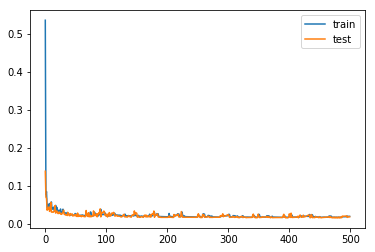

In [106]:
# design network
LSTM_model = Sequential()
LSTM_model.add(LSTM(50, input_shape=(train_input.shape[1], train_input.shape[2])))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mae', optimizer='adam')
# fit network
history = LSTM_model.fit(train_input, train_output, batch_size = 1, epochs = 500, validation_data = (train_input, train_output), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [104]:
LSTM_result = LSTM_model.predict(train_input)

In [105]:
LSTM_predicted_spy_and_original = np.array((LSTM_result, SPMC_SPY_relative_price_benchmark.values[1:]))
LSTM_predicted_spy_and_original = pd.DataFrame(LSTM_predicted_spy_and_original.reshape(20,2))
LSTM_predicted_spy_and_original.columns = ['Prediction', 'Original']
LSTM_predicted_spy_and_original.index = SPMC_SPY_relative_price_benchmark.index[1:]
iplot(LSTM_predicted_spy_and_original.iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Relative Price',title='Predicted SPY vs SPY'))